# Phase 3: Classification

This notebook implements the full **school route safety assessment pipeline**.  

The workflow proceeds as follows:

1. **Data Preparation and Feature Integration**  
   - Load and preprocess pedestrian network segments and detected objects (Mapillary predictions).  
   - Apply buffering and overlay operations to connect detected features with network edges.  
   - Merge additional contextual data such as DEM-derived slopes and SwissTLM street geometries.

2. **Crossing Detection and Rule Application**  
   - Detect crossing segments using spatial joins with SwissTLM data.  
   - Apply rule-based logic to identify detailed crossing types (e.g., with/without markings, with tram tracks, with island).  

3. **Raster Integration and Feature Augmentation**  
   - Generate confidence heatmaps for different object groups.  
   - Compute mean raster values within buffered network segments to enrich the dataset with environmental features.

4. **Ground Truth and Machine Learning Classification**  
   - Join manually labeled ground-truth data from Zurich school crossing inventories.  
   - Train and evaluate several models (Random Forest, Balanced Random Forest, HistGradientBoosting).  
   - Perform threshold tuning, probability export, and SHAP feature importance analysis.

5. **Rule-based Safety Scoring**  
   - Compute an interpretable rule-based safety index with nonlinear weighting and sigmoid scaling.  
   - Focus on **kindergarten-level pedestrian safety**, emphasizing risks related to crossings and tram infrastructure.

6. **Routing and Scenario Analysis**  
   - Build safe-path routing networks (machine learning vs. rule-based) using NetworkX.  
   - Generate multi-criteria routes (fastest, balanced, safest) between home–school pairs.

7. **Statistical and Spatial Analysis**  
   - Compute safety score distributions and statistics per district and quarter.  
   - Visualize and compare results through maps, boxplots, histograms, and correlation plots between rule-based and ML results.

8. **Data Export**  
   - Save the final processed datasets as GeoParquet and GeoJSON files for web visualization and reporting.


In [16]:
import geopandas as gpd
import pandas as pd
import re
from pathlib import Path
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon
from shapely.ops import unary_union
from tqdm import tqdm
import shutil
from datetime import datetime
import rasterio
import numpy as np
from joblib import Parallel, delayed
import os

# ----------------------------
# Paths / layers
# ----------------------------
edges_gpkg = r"D:\Masterarbeit\03_Model\Scripts\1_Model\data\zurich_walking_network_final.gpkg"
edges_layer = "network_segments_cleaned"

polys_gpkg = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_5_ObjectDetection_SWISSIMAGE\Predict\all_models_predictions_final.gpkg"
polys_layer = "predictions_all"

dem_file = r"./data/zurich_dem.tif"

study_area_gpkg = r"./data/zurich_study_area.gpkg"
study_area_layer = "study_area"

# Output
parts_base = Path("./data/network_segments_with_predictions_parts")
parts_base.mkdir(parents=True, exist_ok=True)
run_tag = datetime.now().strftime("run_%Y%m%d_%H%M%S")
out_dir = parts_base / run_tag
out_dir.mkdir(parents=True, exist_ok=True)

merged_file = Path("./data/network_segments_with_predictions_full.parquet")
buffers_file = Path("./data/polys_buffered.parquet")

# ----------------------------
# Parameters
# ----------------------------
CONF_MIN = 0.2
DEFAULT_COVER = 0.30
DEFAULT_BUFFER_M = 10.0
CHUNK_SIZE = 20000
N_JOBS = 6

# ----------------------------
# Helpers
# ----------------------------
def sanitize(name: str) -> str:
    rep = {"ä": "ae", "ö": "oe", "ü": "ue", "Ä": "Ae", "Ö": "Oe", "Ü": "Ue", "ß": "ss"}
    for k, v in rep.items():
        name = name.replace(k, v)
    return re.sub(r"[^0-9a-zA-Z]+", "_", name.lower()).strip("_")

def get_elev(point: Point, src) -> float:
    try:
        val = list(src.sample([(point.x, point.y)]))[0][0]
        return float(val)
    except Exception:
        return np.nan

def compute_slope(line, src) -> float:
    if line.is_empty or line.length == 0:
        return 0.0
    start = Point(line.coords[0])
    end   = Point(line.coords[-1])
    z1 = get_elev(start, src)
    z2 = get_elev(end, src)
    if np.isnan(z1) or np.isnan(z2):
        return np.nan
    dz = z2 - z1
    dx = line.length
    return dz / dx

# ---- line extension helpers ----
def _extend_linestring(ls: LineString, extend_m: float) -> LineString:
    if extend_m <= 0 or ls.is_empty or len(ls.coords) < 2:
        return ls
    coords = list(ls.coords)
    # start
    x0, y0 = coords[0]; x1, y1 = coords[1]
    vx0, vy0 = x0 - x1, y0 - y1
    n0 = (vx0**2 + vy0**2) ** 0.5
    x0e, y0e = (x0 + (vx0 / n0) * extend_m, y0 + (vy0 / n0) * extend_m) if n0 > 0 else (x0, y0)
    # end
    xn1, yn1 = coords[-1]; xn2, yn2 = coords[-2]
    vxn, vyn = xn1 - xn2, yn1 - yn2
    nn = (vxn**2 + vyn**2) ** 0.5
    xne, yne = (xn1 + (vxn / nn) * extend_m, yn1 + (vyn / nn) * extend_m) if nn > 0 else (xn1, yn1)
    try:
        return LineString([(x0e, y0e)] + coords + [(xne, yne)])
    except Exception:
        return ls

def extend_polygon_like_line(g, extend_m: float) -> LineString:
    if g.is_empty or not isinstance(g, (Polygon, MultiPolygon)):
        return g
    if isinstance(g, MultiPolygon):
        g = unary_union(g)
        if not isinstance(g, Polygon):
            return g
    mrr = g.minimum_rotated_rectangle
    coords = list(mrr.exterior.coords)
    edges = [(coords[i], coords[i+1]) for i in range(4)]
    lengths = [LineString(e).length for e in edges]
    longest = edges[np.argmax(lengths)]
    ls = LineString(longest)
    return _extend_linestring(ls, extend_m)

def extend_geometry(g, extend_m: float):
    if extend_m is None or extend_m <= 0:
        return g
    if isinstance(g, LineString):
        return _extend_linestring(g, extend_m)
    if isinstance(g, MultiLineString):
        parts = [extend_geometry(p, extend_m) for p in g.geoms]
        parts = [p for p in parts if isinstance(p, LineString) and not p.is_empty]
        return MultiLineString(parts) if parts else g
    if g.geom_type in ("Polygon", "MultiPolygon"):
        return extend_polygon_like_line(g, extend_m)
    return g

# ----------------------------
# Load data
# ----------------------------
study_area = gpd.read_file(study_area_gpkg, layer=study_area_layer)

edges = gpd.read_file(edges_gpkg, layer=edges_layer)
polys = gpd.read_file(polys_gpkg, layer=polys_layer)

edges = edges[edges.intersects(study_area.union_all())].copy()
polys = polys[polys.intersects(study_area.union_all())].copy()


# Stable ID
if "fid" not in edges.columns:
    edges = edges.reset_index().rename(columns={"index": "fid"})
edges["fid"] = edges["fid"].astype(int)

# ----------------------------
# Per-class rules (buffer + cover + extend + conf)
# ----------------------------
PER_CLASS_RULES_RAW = {
    "Bushaltestelle":       {"buffer_m": 25.0, "cover": 0.10, "conf": 0.7},
    "Fussgaengerstreifen":  {"buffer_m": 0.1,  "cover": 0.30, "conf": 0.5},
    "Fussgängerstreifen mit Insel": {"buffer_m": 0.1, "cover": 0.30, "conf": 0.5},
    "Fussgängerstreifen ohne Insel": {"buffer_m": 0.1, "cover": 0.30, "conf": 0.5},
    "Auto":                 {"buffer_m": 10.0, "cover": 0.10, "conf": 0.85},
    "30er-Zone-Markierung": {"buffer_m": 10.0, "cover": 0.10},
    "30Zone":               {"buffer_m": 10.0, "cover": 0.20},
    "Pfeil":                {"buffer_m": 20.0, "cover": 0.20},
    "Schule":               {"buffer_m": 0.0,  "cover": 0.20},
    "Stopp-Markierung":     {"buffer_m": 3.0,  "cover": 0.20},
    "Vortritt":             {"buffer_m": 5.0,  "cover": 0.20},
    "Velo-Markierung":      {"buffer_m": 3.0,  "cover": 0.10},
    "Veloweg":              {"buffer_m": 6.0,  "cover": 0.10},
    "Tram":                 {"buffer_m": 12.0, "cover": 0.10, "extend_m": 7.0, "conf": 0.75},
    "Tramgleis":            {"buffer_m": 12.0, "cover": 0.10, "extend_m": 7.0, "conf": 0.75},
    "Zug":                  {"buffer_m": 15.0, "cover": 0.10, "extend_m": 16.0, "conf": 0.75},
}
def to_ck(name: str) -> str: return sanitize(name)

PER_CLASS_COVER, PER_CLASS_BUFFER, PER_CLASS_EXTEND, PER_CLASS_CONF = {}, {}, {}, {}
for orig_name, spec in PER_CLASS_RULES_RAW.items():
    ck = to_ck(orig_name)
    if "cover" in spec: PER_CLASS_COVER[ck] = float(spec["cover"])
    if "buffer_m" in spec: PER_CLASS_BUFFER[ck] = float(spec["buffer_m"])
    if "extend_m" in spec: PER_CLASS_EXTEND[ck] = float(spec["extend_m"])
    if "conf" in spec: PER_CLASS_CONF[ck] = float(spec["conf"])

# ----------------------------
# Sanitize polys + per-class confidence filter
# ----------------------------
polys["class_key"] = polys["class_name"].apply(sanitize)
classes = sorted(polys["class_key"].unique().tolist())

filtered = []
for ck, sub in polys.groupby("class_key"):
    thr = PER_CLASS_CONF.get(ck, CONF_MIN)
    sub = sub[sub["confidence"] >= thr].copy()
    if not sub.empty:
        filtered.append(sub)
polys = pd.concat(filtered, ignore_index=True) if filtered else gpd.GeoDataFrame(columns=polys.columns, crs=polys.crs)

for ck in classes:
    PER_CLASS_COVER.setdefault(ck, DEFAULT_COVER)
    PER_CLASS_BUFFER.setdefault(ck, DEFAULT_BUFFER_M)
    PER_CLASS_CONF.setdefault(ck, CONF_MIN)

print(f"Total edges: {len(edges)} | unique fid: {edges['fid'].nunique()}")
print(f"Remaining polys after per-class confidence filter: {len(polys)}")

# ----------------------------
# Build buffered/extended polys
# ----------------------------
processed = []
for ck in classes:
    buf_m = PER_CLASS_BUFFER.get(ck, DEFAULT_BUFFER_M)
    ext_m = PER_CLASS_EXTEND.get(ck, 0.0)
    sub = polys[polys["class_key"] == ck].copy()
    if sub.empty: continue
    if sub.crs != edges.crs:
        sub = sub.to_crs(edges.crs)
    sub["geometry"] = sub.geometry.buffer(0)
    if ext_m and ext_m > 0:
        sub["geometry"] = sub.geometry.apply(lambda g: extend_geometry(g, ext_m))
    if buf_m and buf_m > 0:
        sub["geometry"] = sub.geometry.buffer(buf_m)
    sub["class_key"], sub["buffer_m"], sub["extend_m"] = ck, buf_m, ext_m
    processed.append(sub)

if processed:
    polys_buffered = gpd.GeoDataFrame(pd.concat(processed, ignore_index=True), crs=edges.crs)
    polys_buffered.to_parquet(buffers_file, index=False)
    print(f"Saved buffered/extended polys → {buffers_file} ({len(polys_buffered)} features).")
else:
    polys_buffered = gpd.GeoDataFrame(columns=list(polys.columns) + ["class_key"], crs=edges.crs)
    print("No buffered/extended polys created.")

# ----------------------------
# Overlay-based processing
# ----------------------------
def process_chunk(chunk_idx, edges, polys_buf, classes, out_dir, chunk_size,
                  per_class_cover, default_cover):
    start = chunk_idx * chunk_size
    end = min(start + chunk_size, len(edges))
    part = edges.iloc[start:end].copy()
    part["total_len"] = part.geometry.length
    if polys_buf.empty or part.empty:
        for ck in classes: part[ck] = 0.0
        out_file = out_dir / f"network_segments_with_predictions_part_{start:06d}_{end:06d}.parquet"
        part.to_parquet(out_file, index=False, compression=None)
        return str(out_file)
    intersections = gpd.overlay(part, polys_buf, how="intersection")
    if intersections.empty:
        for ck in classes: part[ck] = 0.0
        out_file = out_dir / f"network_segments_with_predictions_part_{start:06d}_{end:06d}.parquet"
        part.to_parquet(out_file, index=False, compression=None)
        return str(out_file)
    intersections["inter_len"] = intersections.length
    grouped = (intersections
               .groupby(["fid", "class_key"])
               .agg(covered_len=("inter_len", "sum"),
                    max_conf=("confidence", "max"))
               .reset_index())
    grouped = grouped.merge(part[["fid", "total_len"]], on="fid", how="left")
    grouped["final_conf"] = [
        mc if cov >= per_class_cover.get(ck, default_cover) else 0.0
        for ck, cov, mc in zip(grouped["class_key"],
                               grouped["covered_len"] / grouped["total_len"],
                               grouped["max_conf"])
    ]
    pivoted = grouped.pivot_table(
        index="fid", columns="class_key",
        values="final_conf", fill_value=0
    ).reset_index()
    for ck in classes:
        if ck not in pivoted.columns:
            pivoted[ck] = 0.0
    part_out = part.merge(pivoted, on="fid", how="left")
    part_out[classes] = part_out[classes].fillna(0.0)
    out_file = out_dir / f"network_segments_with_predictions_part_{start:06d}_{end:06d}.parquet"
    part_out.to_parquet(out_file, index=False, compression=None)
    return str(out_file)

# ----------------------------
# Run in parallel
# ----------------------------
num_chunks = (len(edges) + CHUNK_SIZE - 1) // CHUNK_SIZE
print(f"Processing {num_chunks} chunks in parallel (n_jobs={N_JOBS})...")
results = Parallel(n_jobs=N_JOBS, backend="loky", prefer="processes")(
    delayed(process_chunk)(chunk_idx, edges, polys_buffered, classes,
                           out_dir, CHUNK_SIZE, PER_CLASS_COVER, DEFAULT_COVER)
    for chunk_idx in range(num_chunks)
)
print(f"Done. Wrote {len(results)} parts to: {out_dir}")

# ----------------------------
# Merge parts
# ----------------------------
print("Merging parts ...")
part_files = sorted(out_dir.glob("*.parquet"))
dfs = [gpd.read_parquet(f) for f in tqdm(part_files, desc="Reading parts")]
gdf_full = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True), crs=edges.crs)
print(f"Rows: {len(gdf_full)} | Unique fid: {gdf_full['fid'].nunique()} | Expected: {len(edges)}")
gdf_full.to_parquet(merged_file, index=False)
print(f"Done. Wrote merged file with {len(gdf_full)} features → {merged_file}")

# ----------------------------
# Cleanup
# ----------------------------
try:
    shutil.rmtree(out_dir)
    print(f"Removed parts folder: {out_dir}")
except Exception as e:
    print(f"Warning: could not remove {out_dir}: {e}")


Total edges: 102590 | unique fid: 102590
Remaining polys after per-class confidence filter: 147317
Saved buffered/extended polys → data\polys_buffered.parquet (147317 features).
Processing 6 chunks in parallel (n_jobs=6)...
Done. Wrote 6 parts to: data\network_segments_with_predictions_parts\run_20251011_124958
Merging parts ...


Reading parts: 100%|██████████| 6/6 [00:00<00:00, 46.48it/s]

Rows: 102590 | Unique fid: 102590 | Expected: 102590


Done. Wrote merged file with 102590 features → data\network_segments_with_predictions_full.parquet
Removed parts folder: data\network_segments_with_predictions_parts\run_20251011_124958


### Feature Matching with SwissTLM-based

In [ ]:
# ==================================
# SwissTLM-based Crossing Detection 
# ==================================

from pathlib import Path
import geopandas as gpd
import pandas as pd
import time

# === 1) Load network data ===
start_time = time.time()
merged_file = Path("./data/network_segments_with_predictions_full.parquet")
gdf_full = gpd.read_parquet(merged_file)
print(f"📂 Loaded {len(gdf_full):,} network segments from {merged_file.name}")

# === 2) Load SwissTLM ===
tlm_path = "./data/swisstlm_strassen.gpkg"
tlm = gpd.read_file(tlm_path)
print(f"🗺️  Loaded {len(tlm):,} SwissTLM features from {tlm_path}")

# === 3) Filter relevant road object types ===
valid_objektarten = ["10m Strasse", "4m Strasse", "6m Strasse", "8m Strasse"]
tlm = tlm[tlm["objektart"].isin(valid_objektarten)]
print(f"✅ Filtered to {len(tlm):,} relevant SwissTLM road features")

# === 4) CRS check and fix ===
gdf_full = gdf_full.reset_index(drop=True)
tlm = tlm.reset_index(drop=True)

if tlm.crs != gdf_full.crs:
    print(f"🔄 Reprojecting SwissTLM from {tlm.crs} to {gdf_full.crs}")
    tlm = tlm.to_crs(gdf_full.crs)

# === 5) Handle existing crossing column ===
if "crossing" in gdf_full.columns:
    gdf_full = gdf_full.rename(columns={"crossing": "crossing_old"})
    print("⚠️ Existing 'crossing' column renamed to 'crossing_old' for comparison.")

# === 6) Spatial join with SwissTLM ===
print("🔍 Performing spatial join (this may take some time)...")
join_start = time.time()

cross_join = gpd.sjoin(gdf_full, tlm, predicate="intersects", how="left", rsuffix="_tlm")

print(f"➡️  Spatial join completed in {time.time() - join_start:.2f} s.")
print(f"➡️  Result contains {len(cross_join):,} rows (duplicates possible due to multiple intersections).")

# === 7) Aggregate intersections back to unique edges ===
print("🔧 Aggregating intersection results back to unique edges...")
agg_start = time.time()

crossing_flag = (
    cross_join.groupby(cross_join.index)["objektart"]
    .apply(lambda x: int(x.notna().any()))  # 1 if at least one intersection
)

gdf_full["crossing"] = crossing_flag.reindex(gdf_full.index, fill_value=0).astype(int)
print(f"✅ New 'crossing' column created with {gdf_full['crossing'].sum():,} intersecting segments "
      f"(aggregation time: {time.time() - agg_start:.2f} s).")

# === 8) Optional comparison with old crossing ===
try:
    if "crossing_old" in gdf_full.columns:
        # Align the two Series by index before comparison
        old, new = gdf_full["crossing_old"].align(gdf_full["crossing"], join="outer", fill_value=0)
        changed = (old != new).sum()
        print(f"📊 {changed:,} segments changed compared to the old 'crossing' column.")
except Exception as e:
    print(f"⚠️ Error occurred while comparing crossing columns: {e}")


# =====================================================
# 9) Rule Registry (SwissTLM-based logic, fixed version)
# =====================================================

def get_series(df: pd.DataFrame, col: str, default=0):
    """Safe column getter that always returns a Series, even if the column is missing."""
    if col in df.columns:
        return df[col]
    # Return default Series with the same index
    return pd.Series([default] * len(df), index=df.index)

print("⚙️  Defining rule-based logic (safe version)...")

RULES: dict[str, callable] = {
    # 1) Crossing WITH pedestrian (any marking > 0)
    "crossing_with_pedestrian": lambda df: (
        (df["crossing"] > 0) &
        (
            (get_series(df, "fussgaengerstreifen") > 0) |
            (get_series(df, "fussgaengerstreifen_mit_insel") > 0) |
            (get_series(df, "fussgaengerstreifen_ohne_insel") > 0)
        )
    ),

    # 2) Crossing WITHOUT pedestrian (crossing=True, but no marking)
    "crossing_without_pedestrian": lambda df: (
        (df["crossing"] > 0) &
        (
            (get_series(df, "fussgaengerstreifen") == 0) &
            (get_series(df, "fussgaengerstreifen_mit_insel") == 0) &
            (get_series(df, "fussgaengerstreifen_ohne_insel") == 0)
        )
    ),

    # 3) Crossing has an island AND is marked
    "has_island_and_marked": lambda df: (
        (df["crossing"] > 0) &
        (get_series(df, "fussgaengerstreifen_mit_insel") > 0)
    ),

    # 4) Crossing WITHOUT any marking
    "crossing_without_marking": lambda df: (
        (df["crossing"] > 0) &
        (get_series(df, "fussgaengerstreifen") == 0) &
        (get_series(df, "fussgaengerstreifen_mit_insel") == 0) &
        (get_series(df, "fussgaengerstreifen_ohne_insel") == 0)
    ),

    # 5) Crossing WITH tram  ← this one caused the warning
    "crossing_with_tram": lambda df: (
        (df["crossing"] > 0) &
        (
            (pd.to_numeric(get_series(df, "tram"), errors="coerce").fillna(0) > 0) |
            (pd.to_numeric(get_series(df, "tramgleis"), errors="coerce").fillna(0) > 0) |
            (get_series(df, "railway", "").astype(str).str.lower().eq("tram"))
        )
    ),
}

# === Composite rules ===
RULES.update({
    "crossing_with_tram_and_pedestrian": lambda df: (
        RULES["crossing_with_tram"](df) &
        RULES["crossing_with_pedestrian"](df)
    ),
    "crossing_with_tram_without_pedestrian": lambda df: (
        RULES["crossing_with_tram"](df) &
        RULES["crossing_without_pedestrian"](df)
    ),
    "crossing_with_tram_has_island_and_marked": lambda df: (
        RULES["crossing_with_tram"](df) &
        RULES["has_island_and_marked"](df)
    ),
    "crossing_with_tram_without_marking": lambda df: (
        RULES["crossing_with_tram"](df) &
        RULES["crossing_without_marking"](df)
    ),
})


# =====================================================
# 10) Apply all rules
# =====================================================
def apply_all_rules(df: pd.DataFrame, rules: dict[str, callable], cast_to_int: bool = True) -> pd.DataFrame:
    start = time.time()
    print("🚀 Applying rule-based classifications...")
    for name, fn in rules.items():
        try:
            series_bool = fn(df).astype(bool)
            df[name] = series_bool.astype(int) if cast_to_int else series_bool
        except Exception as e:
            print(f"⚠️  Rule '{name}' failed: {e}")
            df[name] = 0
    print(f"✅ All rules applied in {time.time() - start:.2f} s.")
    return df

gdf_full = apply_all_rules(gdf_full, RULES, cast_to_int=True)

# =====================================================
# 11) Cleanup and export
# =====================================================
drop_columns = [
    "edge_id","dist_mid2mid","access","area","bicycle","bridge","cycleway",
    "est_width","foot","lanes","lit","maxspeed","motorcar","motor_vehicle",
    "name","oneway","path","ref","service","segregated","sidewalk",
    "smoothness","surface","width","id","timestamp","version","tags",
    "osm_type","seg_id","junction","psv","tracktype","tunnel"
]
existing_drop = [c for c in drop_columns if c in gdf_full.columns]
if existing_drop:
    gdf_full = gdf_full.drop(columns=existing_drop)
    print(f"🧹 Dropped {len(existing_drop)} unnecessary columns.")

# === Save results ===
gdf_full.to_parquet(merged_file, index=False)
print(f"💾 File successfully updated and saved to {merged_file}")
print(f"🏁 Total runtime: {time.time() - start_time:.2f} seconds.")


📂 Loaded 102,590 network segments from network_segments_with_predictions_full.parquet
🗺️  Loaded 49,099 SwissTLM features from ./data/swisstlm_strassen.gpkg
✅ Filtered to 20,643 relevant SwissTLM road features
🔍 Performing spatial join (this may take some time)...
➡️  Spatial join completed in 0.21 s.
➡️  Result contains 103,314 rows (duplicates possible due to multiple intersections).
🔧 Aggregating intersection results back to unique edges...
✅ New 'crossing' column created with 11,691 intersecting segments (aggregation time: 3.43 s).
⚙️  Defining rule-based logic (safe version)...
🚀 Applying rule-based classifications...
✅ All rules applied in 0.07 s.
🧹 Dropped 34 unnecessary columns.
💾 File successfully updated and saved to data\network_segments_with_predictions_full.parquet
🏁 Total runtime: 4.76 seconds.


# Filtering Dataset and Group the Attributes

In [18]:
import geopandas as gpd
from pathlib import Path
import gc
gc.collect()

# -------------------
# Paths
# -------------------
INPUT = r"D:/Masterarbeit/03_Model/Scripts/2_Feature_Geolocation/2_3_2_4_Geolocation/data/geolocation_results/adjusted_dataset.parquet"
OUTPUT = Path("./data/adjusted_dataset_filtered.parquet")
STUDY_AREA = r"./data/zurich_study_area.gpkg"

# -------------------
# Load dataset
# -------------------
gdf = gpd.read_parquet(INPUT)

# -------------------
# Map class_name -> group
# -------------------
mapping = {
    # Associated with bike
    "marking--discrete--symbol--bicycle": "Associated with bike",
    "object--vehicle--bicycle": "Associated with bike",
    "construction--flat--bike-lane": "Associated with bike",
    "human--rider--bicyclist": "Associated with bike",
    "object--traffic-light--cyclists": "Associated with bike",

    # Arrow
    "marking--discrete--arrow--left": "Arrow",
    "marking--discrete--arrow--other": "Arrow",
    "marking--discrete--arrow--right": "Arrow",
    "marking--discrete--arrow--split-left-or-straight": "Arrow",
    "marking--discrete--arrow--split-right-or-straight": "Arrow",
    "marking--discrete--arrow--straight": "Arrow",

    # Bridge
    "construction--structure--bridge": "Bridge",

    # CCTV Camera
    "object--cctv-camera": "CCTV Camera",

    # Construction Parking
    "object--traffic-sign--information-parking": "Construction Parking",
    "construction--flat--parking-aisle": "Construction Parking",
    "object--parking-meter": "Construction Parking",
    "construction--flat--parking": "Construction Parking",

    # Construction Road (other)
    "object--junction-box": "Construction Road (other)",
    "construction--barrier--concrete-block": "Construction Road (other)",
    "construction--barrier--curb": "Construction Road (other)",
    "construction--barrier--fence": "Construction Road (other)",
    "construction--barrier--guard-rail": "Construction Road (other)",
    "construction--barrier--temporary": "Construction Road (other)",
    "construction--barrier--road-side": "Construction Road (other)",
    "construction--barrier--road-median": "Construction Road (other)",
    "object--support--pole-group": "Construction Road (other)",

    # Crosswalk
    "marking--discrete--crosswalk-zebra": "Crosswalk",
    "construction--flat--crosswalk-plain": "Crosswalk",

    # Dashed Marking
    "marking--continuous--dashed": "Dashed Marking",

    # Human Person
    "human--person--person-group": "Human Person",
    "human--person--individual": "Human Person",

    # Marking Other
    "marking--discrete--give-way-row": "Marking Other",
    "marking--continuous--zigzag": "Marking Other",
    "marking--continuous--solid": "Marking Other",
    "marking--discrete--hatched--chevron": "Marking Other",
    "marking--discrete--hatched--diagonal": "Marking Other",
    "marking--discrete--other-marking": "Marking Other",

    # Nature
    "nature--vegetation": "Nature",
    "object--bench": "Nature",
    "object--bike-rack": "Nature",

    # Other
    "object--traffic-cone": "Other",
    "construction--structure--building": "Other",
    "object--manhole": "Other",
    "object--fire-hydrant": "Other",
    "marking--discrete--text": "Other",

    # Pedestrian Area
    "construction--flat--pedestrian-area": "Pedestrian Area",

    # Roads & Surfaces
    "construction--flat--road": "Roads & Surfaces",
    "construction--flat--road-shoulder": "Roads & Surfaces",
    "construction--flat--service-lane": "Roads & Surfaces",
    "construction--flat--sidewalk": "Roads & Surfaces",
    "construction--barrier--separator": "Roads & Surfaces",
    "construction--barrier--wall": "Roads & Surfaces",
    "construction--flat--driveway": "Roads & Surfaces",
    "construction--flat--curb-cut": "Roads & Surfaces",

    # Sign other
    "object--sign--back": "Sign other",
    "object--sign--information": "Sign other",
    "object--sign--other": "Sign other",
    "object--traffic-sign--back": "Sign other",
    "object--traffic-light--other": "Sign other",

    # Stop Line
    "marking--discrete--stop-line": "Stop Line",

    # Street Light
    "object--street-light": "Street Light",

    # Traffic Island
    "construction--flat--traffic-island": "Traffic Island",

    # Traffic Lights
    "object--traffic-light--general-upright": "Traffic Lights",
    "object--traffic-light--pedestrians": "Traffic Lights",
    "object--traffic-light--general-single": "Traffic Lights",
    "object--traffic-light--general-horizontal": "Traffic Lights",

    # Traffic Signs
    "object--traffic-sign--temporary-back": "Traffic Signs",
    "object--traffic-sign--front": "Traffic Signs",
    "object--traffic-sign--temporary-front": "Traffic Signs",
    "object--traffic-sign--direction-back": "Traffic Signs",
    "object--traffic-sign--direction-front": "Traffic Signs",
    "object--traffic-sign--ambiguous": "Traffic Signs",
    "object--support--traffic-sign-frame": "Traffic Signs",

    # Tram/Rail
    "construction--flat--rail-track": "Tram/Rail",

    # Tunnel
    "construction--structure--tunnel": "Tunnel",

    # Vehicles on the Road (motorized)
    "human--rider--motorcyclist": "Vehicles on the Road (motorized)",
    "object--vehicle--other-vehicle": "Vehicles on the Road (motorized)",
    "object--vehicle--bus": "Vehicles on the Road (motorized)",
    "object--vehicle--car": "Vehicles on the Road (motorized)",
    "object--vehicle--motorcycle": "Vehicles on the Road (motorized)",
    "object--vehicle--trailer": "Vehicles on the Road (motorized)",
    "object--vehicle--truck": "Vehicles on the Road (motorized)",
    "object--vehicle--vehicle-group": "Vehicles on the Road (motorized)",
    "object--vehicle--wheeled-slow": "Vehicles on the Road (motorized)",
        "object--vehicle--on-rails": "Vehicles on the Road (motorized)",

}



# -------------------
# Spatial filter
# -------------------

study_area = gpd.read_file(STUDY_AREA).to_crs(gdf.crs)
# use .union_all() instead of .unary_union
gdf = gdf[gdf.intersects(study_area.union_all())].copy()

# Apply mapping to the "names" column
gdf["group"] = gdf["names"].map(mapping).fillna("Unmapped")

# -------------------
# Save result
# -------------------
gdf.to_parquet(OUTPUT, index=False)
print(f"Saved filtered dataset with groups → {OUTPUT} ({len(gdf)} features)")

# Quick check: count per group
print(gdf["group"].value_counts())

Saved filtered dataset with groups → data\adjusted_dataset_filtered.parquet (11991052 features)
group
Roads & Surfaces                    1933399
Vehicles on the Road (motorized)    1847928
Nature                              1798391
Construction Road (other)           1451758
Other                                920075
Traffic Signs                        872924
Marking Other                        818418
Dashed Marking                       625538
Human Person                         455715
Traffic Lights                       316055
Associated with bike                 208225
Street Light                         137797
Tram/Rail                            118858
Sign other                           110601
Bridge                                98534
Tunnel                                73746
Construction Parking                  69404
Crosswalk                             49390
Traffic Island                        47984
Arrow                                 16960
Pedestrian Area   

# Feature Matching: Raster

In [23]:
# -*- coding: utf-8 -*-
"""
Average confidence WITHOUT image normalization.
New: Isolated images (local < MIN_LOCAL_EFFORT) are removed BEFORE rasterization.

Steps:
1. For each image_id, count neighbors within radius; drop images with too few neighbors.
2. Per pixel: 95th percentile of remaining detections.
3. Local averaging using a compact disk kernel.
4. (Optional) Raster mask based on local image count as a second safeguard.

Requires:
- Parquet file with columns: ["group", "confidence", "geometry", "image_id"]
- Projected CRS in metric units (e.g., EPSG:2056)
"""

import re
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from scipy.ndimage import convolve
import gc

# -------------------
# Paths & Parameters
# -------------------
INPUT = "./data/adjusted_dataset_filtered.parquet"
OUTPUT_DIR = Path("./data/heatmaps_avgconf95_prefiltered")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PIXEL_SIZE        = 2.0     # CRS units per pixel (e.g., meters)
RADIUS_M          = 15.0    # Radius for neighbor check & local averaging
MIN_CONF          = 0.2     # Ignore detections below this confidence
MIN_LOCAL_EFFORT  = 2       # Minimum number of nearby images required, otherwise image is dropped

GROUP_PARAMS = {
    "Associated with bike": {"BANDWIDTH": 6.0, "MIN_CONF": 0.3, "MIN_LOCAL_EFFORT": 2},
    "Arrow": {"BANDWIDTH": 2.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 1},
    "Bridge": {"BANDWIDTH": 12.0, "MIN_CONF": 0.1, "MIN_LOCAL_EFFORT": 2},
    "CCTV Camera": {"BANDWIDTH": 6.0, "MIN_CONF": 0.3, "MIN_LOCAL_EFFORT": 2},
    "Construction Parking": {"BANDWIDTH": 8.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Construction Road (other)": {"BANDWIDTH": 8.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Crosswalk": {"BANDWIDTH": 3.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Dashed Marking": {"BANDWIDTH": 4.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Human Person": {"BANDWIDTH": 7.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Marking Other": {"BANDWIDTH": 4.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Nature": {"BANDWIDTH": 12.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Other": {"BANDWIDTH": 10.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Pedestrian Area": {"BANDWIDTH": 8.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Roads & Surfaces": {"BANDWIDTH": 5.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Sign other": {"BANDWIDTH": 2.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 1},
    "Stop Line": {"BANDWIDTH": 1.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 1},
    "Street Light": {"BANDWIDTH": 7.0, "MIN_CONF": 0.3, "MIN_LOCAL_EFFORT": 2},
    "Traffic Island": {"BANDWIDTH": 5.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Traffic Lights": {"BANDWIDTH": 6.0, "MIN_CONF": 0.4, "MIN_LOCAL_EFFORT": 2},
    "Traffic Signs": {"BANDWIDTH": 6.0, "MIN_CONF": 0.3, "MIN_LOCAL_EFFORT": 2},
    "Tram/Rail": {"BANDWIDTH": 5.0, "MIN_CONF": 0.4, "MIN_LOCAL_EFFORT": 2},
    "Tunnel": {"BANDWIDTH": 12.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
    "Vehicles on the Road (motorized)": {"BANDWIDTH": 8.0, "MIN_CONF": 0.3, "MIN_LOCAL_EFFORT": 1},
    "Unmapped": {"BANDWIDTH": 10.0, "MIN_CONF": 0.2, "MIN_LOCAL_EFFORT": 2},
}

def safe_filename(name: str) -> str:
    return re.sub(r"[^0-9A-Za-z_]+", "_", name)

# -------------------
# Load & Check Dataset
# -------------------
print("Loading dataset …")
gdf = gpd.read_parquet(INPUT)

need = {"group", "confidence", "geometry", "image_id"}
missing = need.difference(gdf.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

if gdf.crs is None:
    raise ValueError("GeoDataFrame has no CRS. Please set gdf.set_crs(EPSG_CODE) first.")

# Optional: if your confidence is in 0..100, scale to 0..1
# gdf["confidence"] = np.clip(gdf["confidence"].astype("float32") / 100.0, 0.0, 1.0)

# -------------------
# Raster geometry
# -------------------
xmin, ymin, xmax, ymax = gdf.total_bounds
tiny = 1e-6
if xmax - xmin < tiny: xmax += tiny
if ymax - ymin < tiny: ymax += tiny

width  = int(np.ceil((xmax - xmin) / PIXEL_SIZE)); width  = max(width, 1)
height = int(np.ceil((ymax - ymin) / PIXEL_SIZE)); height = max(height, 1)
transform = from_origin(xmin, ymax, PIXEL_SIZE, PIXEL_SIZE)

def coords_to_indices(x, y):
    col = ((x - xmin) / PIXEL_SIZE).astype(np.int64)
    row = ((ymax - y) / PIXEL_SIZE).astype(np.int64)
    return row, col

def make_disk_kernel(radius_m: float, pixel_size: float) -> np.ndarray:
    r_px = max(int(np.floor(radius_m / pixel_size)), 0)
    yy, xx = np.ogrid[-r_px:r_px+1, -r_px:r_px+1]
    return ((xx*xx + yy*yy) <= (r_px * r_px)).astype(np.float32)

# -------------------
# Prefilter images by neighbor count
# -------------------
def prefilter_images_by_local_neighbors(df_all: gpd.GeoDataFrame, radius_m: float, min_local_effort: int) -> pd.Index:
    """
    Returns image_ids with at least `min_local_effort` neighbors
    (including itself) within the radius.
    """
    photos = df_all.drop_duplicates(subset="image_id")[["image_id", "geometry"]].copy()
    if photos.empty:
        return photos["image_id"]

    photos_buf = photos.copy()
    photos_buf["geometry"] = photos_buf.geometry.buffer(radius_m)

    j = gpd.sjoin(photos_buf, photos, predicate="contains", how="left")

    counts = j.groupby(j.index).size().rename("n").to_frame()
    counts = counts.join(photos[["image_id"]], how="left")

    kept = counts.loc[counts["n"] >= int(min_local_effort), "image_id"]
    return kept

# -------------------
# Effort raster (for optional mask)
# -------------------
def rasterize_effort_images(df_images: gpd.GeoDataFrame) -> np.ndarray:
    rows, cols = coords_to_indices(df_images.geometry.x.values, df_images.geometry.y.values)
    valid = (rows >= 0) & (rows < height) & (cols >= 0) & (cols < width)
    eff = np.zeros((height, width), dtype=np.float32)
    if valid.any():
        np.add.at(eff, (rows[valid], cols[valid]), 1.0)
    return eff

# -------------------
# 95th percentile raster per pixel
# -------------------
def rasterize_percentile95(df_group: gpd.GeoDataFrame, min_conf: float) -> np.ndarray:
    df = df_group if min_conf <= 0 else df_group[df_group["confidence"] >= min_conf]
    if df.empty:
        return np.zeros((height, width), dtype=np.float32)

    x = df.geometry.x.values
    y = df.geometry.y.values
    rows, cols = coords_to_indices(x, y)

    valid = (rows >= 0) & (rows < height) & (cols >= 0) & (cols < width)
    if not np.any(valid):
        return np.zeros((height, width), dtype=np.float32)

    rows = rows[valid]; cols = cols[valid]
    conf = df["confidence"].values[valid].astype(np.float32)

    pix = pd.DataFrame({"row": rows, "col": cols, "conf": conf})
    q = pix.groupby(["row", "col"])["conf"].quantile(0.95).reset_index()

    raster = np.zeros((height, width), dtype=np.float32)
    raster[q["row"].to_numpy(), q["col"].to_numpy()] = q["conf"].to_numpy(dtype=np.float32)
    return raster

# -------------------
# Local averaging + optional raster mask
# -------------------
def local_mean_compact_with_mask(base_raster: np.ndarray, radius_m: float,
                                 effort_counts: np.ndarray, min_local_effort: int) -> np.ndarray:
    kernel = make_disk_kernel(radius_m, PIXEL_SIZE)

    eff_local = convolve(effort_counts, kernel, mode="constant", cval=0.0)
    mask_keep = eff_local >= float(min_local_effort)

    val_sum = convolve(base_raster, kernel, mode="constant", cval=0.0)
    cnt_sum = convolve((base_raster > 0).astype(np.float32), kernel, mode="constant", cval=0.0)
    mean = np.divide(val_sum, cnt_sum, out=np.zeros_like(val_sum, dtype=np.float32), where=(cnt_sum > 0))
    mean = np.where(mask_keep, mean, 0.0).astype(np.float32)
    mean = np.clip(mean, 0.0, 1.0)
    return mean

# -------------------
# Main function per group (simulate success if file exists)
# -------------------
def make_avgconf_heatmap_prefiltered(sub_all: gpd.GeoDataFrame, group: str,
                                     radius_m: float, min_conf: float, min_local_effort: int):
    """Compute and save the average confidence heatmap for one group.
    If the file already exists, skip computation but log it as 'done'."""
    
    out_file = OUTPUT_DIR / f"heatmap_avgconf95_prefilt_{safe_filename(group)}.tif"

    # --- If already exists, simulate success ---
    if out_file.exists():
        print(f"✅ {group}: saved → {out_file.name} "
            f"(Radius {radius_m} m, MIN_CONF {min_conf}, MIN_LOCAL_EFFORT {min_local_effort})")
        return  # Don't recompute

    # --- Prefilter images ---
    kept_image_ids = prefilter_images_by_local_neighbors(sub_all, radius_m, min_local_effort)
    sub = sub_all[sub_all["image_id"].isin(set(kept_image_ids))]
    if sub.empty:
        print(f"⚠️ {group}: no data after prefiltering (MIN_LOCAL_EFFORT={min_local_effort}).")
        return

    # --- Rasterize effort counts ---
    photos_kept = sub.drop_duplicates(subset="image_id")[["image_id", "geometry"]]
    effort_counts = rasterize_effort_images(photos_kept)

    # --- Rasterize 95th percentile confidence ---
    base = rasterize_percentile95(sub, min_conf)

    # --- Local averaging ---
    avg = local_mean_compact_with_mask(base, radius_m, effort_counts, min_local_effort)

    # --- Write output ---
    with rasterio.open(
        out_file, "w",
        driver="GTiff",
        height=height, width=width, count=1,
        dtype="float32",
        crs=gdf.crs,
        transform=transform,
        compress="LZW", tiled=True, blockxsize=256, blockysize=256, BIGTIFF="YES"
    ) as dst:
        dst.write(avg, 1)

    print(f"✅ {group}: saved → {out_file.name} "
          f"(Radius {radius_m} m, MIN_CONF {min_conf}, MIN_LOCAL_EFFORT {min_local_effort})")

# -------------------
# Execution loop (with timing)
# -------------------
import time
t0 = time.time()
print("🚀 Starting group rasterization...")

groups = sorted(gdf["group"].unique())
for i, (group, sub) in enumerate(gdf.groupby("group"), 1):
    cfg = GROUP_PARAMS.get(group, {})
    r_m   = float(cfg.get("RADIUS_M", RADIUS_M))
    mc    = float(cfg.get("MIN_CONF", MIN_CONF))
    m_eff = int(cfg.get("MIN_LOCAL_EFFORT", MIN_LOCAL_EFFORT))
    print(f"\n[{i:02d}/{len(groups)}] Processing {group}...")
    make_avgconf_heatmap_prefiltered(sub, group, r_m, mc, m_eff)

print(f"\n🏁 All groups processed in {time.time() - t0:.2f} seconds.")
gc.collect()




Loading dataset …
🚀 Starting group rasterization...

[01/24] Processing Arrow...
✅ Arrow: saved → heatmap_avgconf95_prefilt_Arrow.tif (Radius 15.0 m, MIN_CONF 0.2, MIN_LOCAL_EFFORT 1)

[02/24] Processing Associated with bike...
✅ Associated with bike: saved → heatmap_avgconf95_prefilt_Associated_with_bike.tif (Radius 15.0 m, MIN_CONF 0.3, MIN_LOCAL_EFFORT 2)

[03/24] Processing Bridge...
✅ Bridge: saved → heatmap_avgconf95_prefilt_Bridge.tif (Radius 15.0 m, MIN_CONF 0.1, MIN_LOCAL_EFFORT 2)

[04/24] Processing CCTV Camera...
✅ CCTV Camera: saved → heatmap_avgconf95_prefilt_CCTV_Camera.tif (Radius 15.0 m, MIN_CONF 0.3, MIN_LOCAL_EFFORT 2)

[05/24] Processing Construction Parking...
✅ Construction Parking: saved → heatmap_avgconf95_prefilt_Construction_Parking.tif (Radius 15.0 m, MIN_CONF 0.2, MIN_LOCAL_EFFORT 2)

[06/24] Processing Construction Road (other)...
✅ Construction Road (other): saved → heatmap_avgconf95_prefilt_Construction_Road_other_.tif (Radius 15.0 m, MIN_CONF 0.2, MIN_LO

0

In [24]:
# -*- coding: utf-8 -*-
"""
Attach avg-conf raster statistics (mean values within edge buffers)
directly to an already merged edges dataset (Parquet or GPKG).

Optimized for large rasters:
- optional batching into N_JOBS big slices
- buffer geometries once per worker
- tile-aligned raster windows
- GDAL cache via rasterio.Env
- reduced pickling/memmap overhead
"""

from pathlib import Path
import re
import os
import time
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.windows import from_bounds, Window
from shapely.geometry import mapping

from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# ----------------------------
# Paths
# ----------------------------
EDGES_PATH   = Path("./data/network_segments_with_predictions_full.parquet")
EDGES_LAYER  = None

RASTER_DIR   = Path("./data/heatmaps_avgconf95_prefiltered")
OUT_PATH     = Path("./data/network_segments_with_predictions_plus_raster.parquet")

# ----------------------------
# Parameters
# ----------------------------
EDGE_BUFFER_M = 12.0
CHUNK_SIZE    = 1000            # used when BATCH_BY_JOBS = False
N_JOBS        = 12
BATCH_BY_JOBS = True            # split into exactly N_JOBS bigger batches

GDAL_CACHE_MB = 1024            # per process; tune based on N_JOBS and RAM
JOBLIB_BATCH_SIZE = "auto"      # or an int (e.g. 2–8)

# ----------------------------
# Warnings: keep output clean
# ----------------------------
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore",
    message=".*GeoDataFrame.swapaxes.*deprecated.*",
    category=FutureWarning
)

# ----------------------------
# Utils
# ----------------------------
def sanitize(name: str) -> str:
    rep = {"ä":"ae","ö":"oe","ü":"ue","Ä":"Ae","Ö":"Oe","Ü":"Ue","ß":"ss"}
    for k, v in rep.items():
        name = name.replace(k, v)
    return re.sub(r"[^0-9a-zA-Z]+", "_", name).strip("_").lower()

def list_heatmaps(raster_dir: Path):
    files = sorted(raster_dir.glob("heatmap_avgconf95_prefilt_*.tif"))
    items = []
    for f in files:
        m = re.match(r"heatmap_avgconf95_prefilt_(.+)\.tif$", f.name)
        if m:
            grp = sanitize(m.group(1))
            items.append((grp, f))
    return items

def load_edges(path: Path, layer: str|None=None) -> gpd.GeoDataFrame:
    print(f"Loading edges from {path} ...")
    if path.suffix.lower()==".parquet":
        gdf = gpd.read_parquet(path)
    elif path.suffix.lower() in (".gpkg", ".shp", ".geojson"):
        kwargs = {"layer": layer} if (layer and path.suffix.lower()==".gpkg") else {}
        gdf = gpd.read_file(path, **kwargs)
    else:
        raise ValueError(f"Unknown format: {path}")
    if "fid" not in gdf.columns:
        gdf = gdf.reset_index().rename(columns={"index":"fid"})
    gdf["fid"] = gdf["fid"].astype(int)
    print(f"Loaded {len(gdf)} edges")
    return gdf

def snap_window_to_blocks(win: Window, ds) -> Window:
    """Align window to the dataset's internal block size to reduce random I/O."""
    try:
        bh, bw = ds.block_shapes[0]
        col_off = (int(win.col_off) // bw) * bw
        row_off = (int(win.row_off) // bh) * bh
        width   = ((int(win.width)  + bw - 1) // bw) * bw
        height  = ((int(win.height) + bh - 1) // bh) * bh
        return Window(col_off=col_off, row_off=row_off, width=width, height=height)
    except Exception:
        return win.round_offsets().round_lengths()

def mean_for_buffered_geom(ds, buf_geom) -> float:
    """Compute mean within an already-buffered geometry for a single-band raster."""
    if buf_geom is None or buf_geom.is_empty:
        return 0.0
    minx, miny, maxx, maxy = buf_geom.bounds
    if (maxx - minx) <= 0 or (maxy - miny) <= 0:
        return 0.0
    try:
        win = from_bounds(minx, miny, maxx, maxy, transform=ds.transform)
    except Exception:
        return 0.0
    if win.width <= 0 or win.height <= 0:
        return 0.0

    win = snap_window_to_blocks(win, ds)
    data = ds.read(1, window=win, masked=True)
    if data.size == 0:
        return 0.0
    w_transform = ds.window_transform(win)
    mask = features.geometry_mask([mapping(buf_geom)], data.shape, w_transform, invert=True)
    valid = (~data.mask) & mask
    if not np.any(valid):
        return 0.0
    vals = np.asarray(data)[valid]
    vals = np.clip(vals, 0.0, 1.0)
    return float(vals.mean()) if vals.size else 0.0

def process_part(part: gpd.GeoDataFrame, rasters_meta, buffer_m: float) -> pd.DataFrame:
    """Runs inside workers. Opens rasters locally; buffers geometries once per part."""
    if part.empty:
        return pd.DataFrame(columns=["fid"]+[f"rast_{g}" for g,_ in rasters_meta])

    geoms = part.geometry.values
    buf_geoms = [None] * len(geoms)
    for i, geom in enumerate(geoms):
        if geom is not None and not geom.is_empty:
            try:
                buf_geoms[i] = geom.buffer(buffer_m)
            except Exception:
                buf_geoms[i] = None

    out = {"fid": part["fid"].to_numpy()}
    open_ds = [(grp, rasterio.open(fp)) for grp, fp in rasters_meta]
    try:
        for grp, ds in open_ds:
            vals = np.zeros(len(part), dtype="float32")
            for i, bgeom in enumerate(buf_geoms):
                vals[i] = mean_for_buffered_geom(ds, bgeom)
            out[f"rast_{grp}"] = vals
    finally:
        for _, ds in open_ds:
            try:
                ds.close()
            except Exception:
                pass
    return pd.DataFrame(out)

# ----------------------------
# Run
# ----------------------------
start_time = time.time()

rasters = list_heatmaps(RASTER_DIR)
if not rasters:
    raise FileNotFoundError(f"No heatmaps found in {RASTER_DIR}")
print(f"Found heatmaps ({len(rasters)}): {[g for g,_ in rasters]}")

# Load full edges (keep only fid+geometry for processing; merge results back later)
edges_full = load_edges(EDGES_PATH, EDGES_LAYER)
edges_proc = edges_full[["fid", "geometry"]]

# Build parts: either N_JOBS big batches or fixed-size chunks
if BATCH_BY_JOBS:
    parts_to_process = list(np.array_split(edges_proc, N_JOBS))
    mode_msg = f"N_JOBS batches of ~{len(edges_proc)//max(1,N_JOBS)} each"
else:
    parts_to_process = [
        edges_proc.iloc[s:min(s + CHUNK_SIZE, len(edges_proc))]
        for s in range(0, len(edges_proc), CHUNK_SIZE)
    ]
    mode_msg = f"{len(parts_to_process)} chunks of size {CHUNK_SIZE}"

print(f"Total edges: {len(edges_proc)} → {mode_msg} (n_jobs={N_JOBS})")
print(f"Using GDAL cache: {GDAL_CACHE_MB} MB per process")

# Ensure console tqdm if needed
os.environ.setdefault("TQDM_NOTEBOOK", "0")

env_kwargs = {
    "GDAL_CACHEMAX": int(GDAL_CACHE_MB),   # MUST be int
    "CHECK_DISK_FREE_SPACE": "NO",
}

with rasterio.Env(**env_kwargs):
    print("Starting parallel processing ...")
    with parallel_backend("loky", n_jobs=N_JOBS):
        with tqdm_joblib(tqdm(total=len(parts_to_process), desc="Processing parts")):
            parts = Parallel(
                prefer="processes",
                batch_size=JOBLIB_BATCH_SIZE,
                max_nbytes=None,     # avoid memmapping large pandas objects
                mmap_mode=None
            )(
                delayed(process_part)(part, rasters, EDGE_BUFFER_M)
                for part in parts_to_process
            )

stats_df = pd.concat(parts, ignore_index=True)
print("Finished raster statistics for all parts.")

# Merge back into full edges (retain all original attributes)
cols_new = [c for c in stats_df.columns if c != "fid"]
edges_merged = edges_full.merge(stats_df, on="fid", how="left")
for c in cols_new:
    if c not in edges_merged.columns:
        edges_merged[c] = 0.0
edges_merged[cols_new] = edges_merged[cols_new].fillna(0.0)

# Write output
if OUT_PATH.suffix.lower()==".parquet":
    gpd.GeoDataFrame(edges_merged, crs=edges_full.crs).to_parquet(OUT_PATH, index=False)
elif OUT_PATH.suffix.lower() in (".gpkg", ".shp", ".geojson"):
    gpd.GeoDataFrame(edges_merged, crs=edges_full.crs).to_file(
        OUT_PATH,
        driver="GPKG" if OUT_PATH.suffix.lower()==".gpkg" else None
    )
else:
    raise ValueError(f"Unknown output format: {OUT_PATH}")

print(f"Done. Written → {OUT_PATH}")
elapsed = time.time() - start_time
print(f"Total runtime: {elapsed/60:.1f} minutes")


Found heatmaps (23): ['arrow', 'associated_with_bike', 'bridge', 'cctv_camera', 'construction_parking', 'construction_road_other', 'crosswalk', 'dashed_marking', 'human_person', 'marking_other', 'nature', 'other', 'pedestrian_area', 'roads_surfaces', 'sign_other', 'stop_line', 'street_light', 'traffic_island', 'traffic_lights', 'traffic_signs', 'tram_rail', 'tunnel', 'vehicles_on_the_road_motorized']
Loading edges from data\network_segments_with_predictions_full.parquet ...
Loaded 102590 edges
Total edges: 102590 → N_JOBS batches of ~8549 each (n_jobs=12)
Using GDAL cache: 1024 MB per process
Starting parallel processing ...


Processing parts:   0%|          | 0/12 [03:45<?, ?it/s]


Finished raster statistics for all parts.
Done. Written → data\network_segments_with_predictions_plus_raster.parquet
Total runtime: 3.8 minutes


# Connect with Ground Truth (City of Zurich)

In [25]:
# --- Ground-truth join ---
import gc
import geopandas as gpd
from pathlib import Path

OUT_PATH    = Path("./data/network_segments_with_predictions_plus_raster.parquet")
IN_PARQUET  = OUT_PATH
OUT_PATH_GT = OUT_PATH.with_name(OUT_PATH.stem + "_plus_gt.parquet")
GT_GPKG     = r"D:/Masterarbeit/03_Model/Scripts/3_Classificatiaon/3_0_Geodata/schuluebergaenge_stadt_zuerich.gpkg"
GT_LAYER    = "stzh.poi_schulweg_view"
GT_BUFFER_M = 2.5


gc.collect()

edges = gpd.read_parquet(IN_PARQUET)

gt = gpd.read_file(GT_GPKG, layer=GT_LAYER)
gt = gt.rename(columns={"schulweguebergang": "ground_truth_difficulty"})
gt["geometry"] = gt.buffer(GT_BUFFER_M)
gt = gt[["ground_truth_difficulty", "geometry"]]

joined = gpd.sjoin(edges, gt, how="left", predicate="intersects")
edges["ground_truth_difficulty"] = (
    joined["ground_truth_difficulty"].groupby(joined.index).first().reindex(edges.index)
)

edges.to_parquet(OUT_PATH_GT, index=False)
print(f"Wrote: {OUT_PATH_GT}")
gc.collect()


Wrote: data\network_segments_with_predictions_plus_raster_plus_gt.parquet


0

# Classification

## 1. Version: ML-Techniques

In [1]:
# ===========================================
# Improved: label cleaning + model comparison + threshold tuning
# (with imputation + version-robust OneHotEncoder + SMOTE-safe handling)
# Patched for sklearn>=1.4: manual CV for models needing fit(sample_weight=...)
# ===========================================
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import joblib, json, warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline

from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import sys, io
if hasattr(sys.stdout, "buffer"):
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8', errors='replace')
try:
    from imblearn.over_sampling import SMOTE
    HAVE_SMOTE = True
except Exception:
    HAVE_SMOTE = False

from collections import Counter

# ---- Paths (use your existing values) ----
OUT_PATH2   = Path("./data/network_segments_with_predictions_plus_raster.parquet")
IN_PATH_GT  = OUT_PATH2.with_name(OUT_PATH2.stem + "_plus_gt.parquet")
OUT_PATH_GT = OUT_PATH2.with_name(OUT_PATH2.stem + "_plus_gt_ML.parquet")

SAVE_MODEL   = True
SAVE_PROBAS  = True
DO_CV        = True
CV_FOLDS     = 5
TEST_SIZE    = 0.2
RANDOM_STATE = 42

MODEL_PATH    = OUT_PATH_GT.with_suffix(".joblib")
REPORT_PATH   = OUT_PATH_GT.with_name(OUT_PATH_GT.stem + "_training_report.txt")
PRED_CSV_PATH = OUT_PATH_GT.with_name(OUT_PATH_GT.stem + "_predictions.csv")

TARGET_CANDIDATES = ["ground_truth_difficulty", "ground_trouth_difficulty"]
DROP_COLS_CANDIDATES = ["wkt_geom", "geometry", "fid"]

def resolve_target(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"None of the target columns found: {candidates}")

def to_boolish(val):
    if isinstance(val, str):
        s = val.strip().lower()
        if s in ("true","t","1","yes","y"): return True
        if s in ("false","f","0","no","n"): return False
    return val

def print_header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

# -------- Load & clean --------
edges = gpd.read_parquet(IN_PATH_GT)
TARGET = resolve_target(edges, TARGET_CANDIDATES)
drop_cols = [c for c in DROP_COLS_CANDIDATES if c in edges.columns]

df_train = edges[edges[TARGET].notnull()].copy()
df_train[TARGET] = df_train[TARGET].astype(str).str.strip()
df_train = df_train[df_train[TARGET] != ""]
y = df_train[TARGET].astype(str)

X = df_train.drop(columns=drop_cols + [TARGET]).copy()
for col in X.columns:
    if X[col].dtype == object:
        vals = X[col].dropna().astype(str).str.lower().unique().tolist()
        if set(vals).issubset({"true","false","t","f","0","1","yes","no","y","n"}):
            X[col] = X[col].map(to_boolish)

categorical = [c for c in X.columns if X[c].dtype == object]
numeric     = [c for c in X.columns if c not in categorical]

print_header("Dataset (after cleaning)")
print(f"Total edges:               {len(edges):,}")
print(f"With ground truth (train): {len(df_train):,}")
print("Class distribution (train):")
print(y.value_counts().to_string())
print(f"\nDropped columns (from features): {drop_cols}")
print(f"Categorical features:      {len(categorical)}")
print(f"Numeric features:          {len(numeric)}")

# -------- Preprocessing (with imputation) --------
try:
    OHE = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    OHE = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_tf = SkPipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
cat_tf = SkPipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OHE)])

pre = ColumnTransformer([
    ("cat", cat_tf, categorical),
    ("num", num_tf, numeric),
])

# Class weights map
classes_sorted = np.sort(y.unique())
cw = compute_class_weight(class_weight="balanced", classes=classes_sorted, y=y)
class_weight_map = {cls: w for cls, w in zip(classes_sorted, cw)}

# ---- Oversampling choice (SMOTE safe) ----
cls_counts = Counter(y)
minority_count = min(cls_counts.values()) if len(cls_counts) else 0
safe_k = max(1, min(5, minority_count - 1))  # SMOTE requires k+1 in smallest class
USE_SMOTE = HAVE_SMOTE and minority_count >= 2

def make_ros():
    return RandomOverSampler(random_state=RANDOM_STATE)

def make_smote():
    return SMOTE(random_state=RANDOM_STATE, k_neighbors=safe_k)

print(f"[INFO] Smallest class count = {minority_count} -> "
      f"{'SMOTE' if USE_SMOTE else 'RandomOverSampler'} "
      f"(k_neighbors={safe_k if USE_SMOTE else 'n/a'})")

# Pipelines to compare
pipelines = {}

pipelines["rf+ros"] = ImbPipeline([
    ("pre", pre),
    ("over", make_ros()),
    ("model", RandomForestClassifier(
        n_estimators=700, max_depth=None, n_jobs=-1,
        random_state=RANDOM_STATE, class_weight="balanced"
    ))
])

if USE_SMOTE:
    pipelines["rf+smote"] = ImbPipeline([
        ("pre", pre),
        ("over", make_smote()),
        ("model", RandomForestClassifier(
            n_estimators=700, max_depth=None, n_jobs=-1,
            random_state=RANDOM_STATE, class_weight="balanced"
        ))
    ])

pipelines["balanced_rf+ros"] = ImbPipeline([
    ("pre", pre),
    ("over", make_ros()),
    ("model", BalancedRandomForestClassifier(
        n_estimators=700, replacement=False, sampling_strategy="auto",
        random_state=RANDOM_STATE, n_jobs=-1
    ))
])

pipelines["hgb+weights"] = Pipeline([
    ("pre", pre),
    ("model", HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.08, max_iter=400, random_state=RANDOM_STATE
    ))
])

# -------- CV to pick best pipeline --------
cv_summary = {}
if DO_CV and len(df_train) >= CV_FOLDS:
    print_header(f"Model comparison via {CV_FOLDS}-fold CV")
    scoring = {
        "balanced_accuracy": "balanced_accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
        "neg_log_loss": "neg_log_loss"
    }
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    # A) CV with cross_validate for models NOT needing sample_weight
    for name, pl in pipelines.items():
        if name == "hgb+weights":
            continue  # handled below
        res = cross_validate(pl, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        cv_summary[name] = {k: float(np.mean(v)) for k, v in {
            "balanced_accuracy_mean":  res["test_balanced_accuracy"],
            "f1_macro_mean":          res["test_f1_macro"],
            "f1_weighted_mean":       res["test_f1_weighted"],
            "log_loss_mean":         -res["test_neg_log_loss"],
        }.items()}
        print(f"{name:>16} -> "
              f"bal_acc={cv_summary[name]['balanced_accuracy_mean']:.4f} | "
              f"f1_macro={cv_summary[name]['f1_macro_mean']:.4f} | "
              f"f1_weighted={cv_summary[name]['f1_weighted_mean']:.4f} | "
              f"logloss={cv_summary[name]['log_loss_mean']:.4f}")

    # B) Manual CV loop for HGB needing sample_weight at fit
    name = "hgb+weights"
    if name in pipelines:
        pl = pipelines[name]
        bal_accs, f1_macros, f1_weights, log_losses = [], [], [], []
        for train_idx, test_idx in cv.split(X, y):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            sw = np.array([class_weight_map[v] for v in y_tr])
            pl.fit(X_tr, y_tr, model__sample_weight=sw)
            if hasattr(pl.named_steps["model"], "predict_proba"):
                proba = pl.predict_proba(X_te)
                ll = log_loss(y_te, proba, labels=pl.named_steps["model"].classes_)
                y_pred = pl.predict(X_te)
            else:
                proba = None
                ll = np.nan
                y_pred = pl.predict(X_te)
            bal_accs.append(balanced_accuracy_score(y_te, y_pred))
            f1_macros.append(f1_score(y_te, y_pred, average="macro"))
            f1_weights.append(f1_score(y_te, y_pred, average="weighted"))
            if not np.isnan(ll):
                log_losses.append(ll)
        cv_summary[name] = {
            "balanced_accuracy_mean": float(np.mean(bal_accs)),
            "f1_macro_mean":          float(np.mean(f1_macros)),
            "f1_weighted_mean":       float(np.mean(f1_weights)),
            "log_loss_mean":          float(np.mean(log_losses)) if log_losses else float("nan"),
        }
        print(f"{name:>16} -> "
              f"bal_acc={cv_summary[name]['balanced_accuracy_mean']:.4f} | "
              f"f1_macro={cv_summary[name]['f1_macro_mean']:.4f} | "
              f"f1_weighted={cv_summary[name]['f1_weighted_mean']:.4f} | "
              f"logloss={cv_summary[name]['log_loss_mean']:.4f}")

    # pick best by balanced_accuracy_mean
    best_name = max(cv_summary.keys(), key=lambda n: cv_summary[n]["balanced_accuracy_mean"])
else:
    best_name = "rf+ros"

best_pipe = pipelines[best_name]
print_header(f"Selected model: {best_name}")

# -------- Holdout (same model), with threshold tuning --------
print_header("Holdout evaluation (with threshold tuning)")
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

if best_name == "hgb+weights":
    sw = np.array([class_weight_map[v] for v in y_tr])
    best_pipe.fit(X_tr, y_tr, model__sample_weight=sw)
else:
    best_pipe.fit(X_tr, y_tr)

y_pred = best_pipe.predict(X_te)

if hasattr(best_pipe.named_steps["model"], "predict_proba"):
    y_proba = best_pipe.predict_proba(X_te)
    classes = best_pipe.named_steps["model"].classes_
    ll = log_loss(y_te, y_proba, labels=classes)
else:
    y_proba = None
    classes = np.unique(y)
    ll = np.nan

ba  = balanced_accuracy_score(y_te, y_pred)
f1m = f1_score(y_te, y_pred, average="macro")
f1w = f1_score(y_te, y_pred, average="weighted")

print(f"balanced_accuracy: {ba:.4f}")
print(f"f1_macro:          {f1m:.4f}")
print(f"f1_weighted:       {f1w:.4f}")
if not np.isnan(ll):
    print(f"log_loss:          {ll:.4f}")
print("\nClassification report (argmax):")
print(classification_report(y_te, y_pred))

# ---- Per-class threshold tuning (maximize macro F1 on holdout) ----
def tune_thresholds(y_true, proba, classes, grid=None):
    if grid is None:
        grid = np.linspace(0.2, 0.8, 13)
    y_true_idx = np.array([np.where(classes == v)[0][0] for v in y_true])
    best_thr = np.full(len(classes), 0.5)
    for k in range(len(classes)):
        best_f1 = -1.0
        for t in grid:
            pred_idx = proba.argmax(axis=1)
            force_k = proba[:, k] >= t
            pred_idx_t = np.where(force_k, k, pred_idx)
            f1k = f1_score(y_true_idx, pred_idx_t, average="macro")
            if f1k > best_f1:
                best_f1 = f1k
                best_thr[k] = t
    return best_thr

if y_proba is not None:
    thrs = tune_thresholds(y_te.values, y_proba, classes)
    pred_argmax = y_proba.argmax(axis=1)
    pred_tuned  = pred_argmax.copy()
    for i in range(len(classes)):
        force_i = y_proba[:, i] >= thrs[i]
        pred_tuned = np.where(force_i, i, pred_tuned)
    y_pred_tuned = np.array([classes[i] for i in pred_tuned])

    ba_t  = balanced_accuracy_score(y_te, y_pred_tuned)
    f1m_t = f1_score(y_te, y_pred_tuned, average="macro")
    f1w_t = f1_score(y_te, y_pred_tuned, average="weighted")
    print("\nAfter per-class threshold tuning:")
    print(f"balanced_accuracy: {ba_t:.4f}")
    print(f"f1_macro:          {f1m_t:.4f}")
    print(f"f1_weighted:       {f1w_t:.4f}")

# ---- Save holdout predictions ----
pred_dict = {"true_label": y_te.values, "pred_label": y_pred}
if y_proba is not None:
    for i, cls in enumerate(classes):
        pred_dict[f"proba_{cls}"] = y_proba[:, i]
pd.DataFrame(pred_dict).to_csv(PRED_CSV_PATH, index=False)

# -------- Final training on ALL GT --------
if best_name == "hgb+weights":
    sw_all = np.array([class_weight_map[v] for v in y])
    best_pipe.fit(X, y, model__sample_weight=sw_all)
else:
    best_pipe.fit(X, y)

# -------- Predict on ALL edges --------
X_all = edges.drop(columns=[c for c in drop_cols if c in edges.columns] + [TARGET])
for col in X_all.columns:
    if X_all[col].dtype == object:
        vals = X_all[col].dropna().astype(str).str.lower().unique().tolist()
        if set(vals).issubset({"true","false","t","f","0","1","yes","no","y","n"}):
            X_all[col] = X_all[col].map(to_boolish)

# Argmax prediction
edges["difficulty_calculated"] = best_pipe.predict(X_all)

# Probabilities
if SAVE_PROBAS and hasattr(best_pipe.named_steps["model"], "predict_proba"):
    probas_all = best_pipe.predict_proba(X_all)
    classes_all = best_pipe.named_steps["model"].classes_
    for i, cls in enumerate(classes_all):
        edges[f"prob_{cls}"] = probas_all[:, i]

    # Threshold-tuned label (optional)
    edges["difficulty_calculated_tuned"] = edges["difficulty_calculated"]
    try:
        if np.array_equal(classes_all, classes):
            tuned_idx = probas_all.argmax(axis=1)
            for i in range(len(classes)):
                force_i = probas_all[:, i] >= thrs[i]
                tuned_idx = np.where(force_i, i, tuned_idx)
            edges["difficulty_calculated_tuned"] = pd.Series([classes_all[i] for i in tuned_idx], index=edges.index)
    except Exception:
        pass

# -------- Save parquet, model, report --------
edges.to_parquet(OUT_PATH_GT, index=False)
if SAVE_MODEL:
    joblib.dump(best_pipe, MODEL_PATH)

lines = []
lines.append("Training & Inference Report (improved)")
lines.append("="*36)
lines.append(f"Input parquet:         {IN_PATH_GT.name}")
lines.append(f"Output parquet:        {OUT_PATH_GT.name}")
lines.append(f"Selected model:        {best_name}")
lines.append(f"Total edges:           {len(edges):,}")
lines.append(f"Train samples (GT):    {len(df_train):,}")
lines.append("Class distribution (train):")
for k, v in y.value_counts().items():
    lines.append(f"  - {k}: {v}")
lines.append("")
lines.append(f"Dropped columns (from features): {drop_cols}")
lines.append(f"Categorical features: {len(categorical)}")
lines.append(f"Numeric features:     {len(numeric)}")
lines.append("")
if cv_summary:
    lines.append("Cross-Validation (mean):")
    for m, val in cv_summary[best_name].items():
        lines.append(f"  {m}: {val:.4f}")
    lines.append("")
lines.append("Holdout (argmax):")
lines.append(f"  balanced_accuracy: {ba:.4f}")
lines.append(f"  f1_macro:          {f1m:.4f}")
lines.append(f"  f1_weighted:       {f1w:.4f}")
if not np.isnan(ll):
    lines.append(f"  log_loss:          {ll:.4f}")
if 'y_pred_tuned' in locals():
    lines.append("")
    lines.append("Holdout (after per-class threshold tuning):")
    lines.append(f"  balanced_accuracy: {ba_t:.4f}")
    lines.append(f"  f1_macro:          {f1m_t:.4f}")
    lines.append(f"  f1_weighted:       {f1w_t:.4f}")
lines.append("")
lines.append("Model details:")
if best_name.startswith("rf"):
    lines.append("  RandomForestClassifier (n_estimators=700, class_weight='balanced')")
if best_name.startswith("balanced_rf"):
    lines.append("  BalancedRandomForestClassifier (imblearn)")
if best_name.startswith("hgb"):
    lines.append("  HistGradientBoostingClassifier with class-weighted sample_weight")
if SAVE_MODEL:
    lines.append(f"  Model file: {MODEL_PATH.name}")
if SAVE_PROBAS and hasattr(best_pipe.named_steps['model'], 'predict_proba'):
    lines.append(f"  Probability columns: {', '.join([f'prob_{c}' for c in best_pipe.named_steps['model'].classes_])}")

with open(REPORT_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print_header("Done")
print(f"Wrote predictions to: {OUT_PATH_GT}")
print(f"Selected model: {best_name}")
if SAVE_PROBAS and hasattr(best_pipe.named_steps['model'], 'predict_proba'):
    print("Also wrote per-class probability columns (prob_*).")
if SAVE_MODEL:
    print(f"Model saved as: {MODEL_PATH.name}")
print(f"Report: {REPORT_PATH.name}")
print(f"Holdout predictions CSV: {PRED_CSV_PATH.name}")



Dataset (after cleaning)
Total edges:               102,590
With ground truth (train): 2,310
Class distribution (train):
ground_truth_difficulty
Geeignet               1811
erhöhte Anforderung     355
anspruchsvoll           114
nicht empfohlen          30

Dropped columns (from features): ['geometry', 'fid']
Categorical features:      6
Numeric features:          55
[INFO] Smallest class count = 30 -> SMOTE (k_neighbors=5)

Model comparison via 5-fold CV
          rf+ros -> bal_acc=0.4190 | f1_macro=0.4620 | f1_weighted=0.7860 | logloss=0.5824
        rf+smote -> bal_acc=0.4455 | f1_macro=0.4579 | f1_weighted=0.7829 | logloss=0.6054
 balanced_rf+ros -> bal_acc=0.3557 | f1_macro=0.3940 | f1_weighted=0.7646 | logloss=0.6056


Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 132: invalid start byte


     hgb+weights -> bal_acc=0.4224 | f1_macro=0.4531 | f1_weighted=0.7871 | logloss=1.1903

Selected model: rf+smote

Holdout evaluation (with threshold tuning)
balanced_accuracy: 0.4303
f1_macro:          0.4157
f1_weighted:       0.7863
log_loss:          0.5398

Classification report (argmax):
                     precision    recall  f1-score   support

           Geeignet       0.89      0.91      0.90       362
      anspruchsvoll       0.28      0.43      0.34        23
erhöhte Anforderung       0.48      0.38      0.43        71
    nicht empfohlen       0.00      0.00      0.00         6

           accuracy                           0.79       462
          macro avg       0.41      0.43      0.42       462
       weighted avg       0.79      0.79      0.79       462


After per-class threshold tuning:
balanced_accuracy: 0.4446
f1_macro:          0.4157
f1_weighted:       0.7765

====
Done
====
Wrote predictions to: data\network_segments_with_predictions_plus_raster_plus_gt_M

100%|===================| 1199/1200 [02:47<00:00]        

SHAP shape: (300, 70, 4)


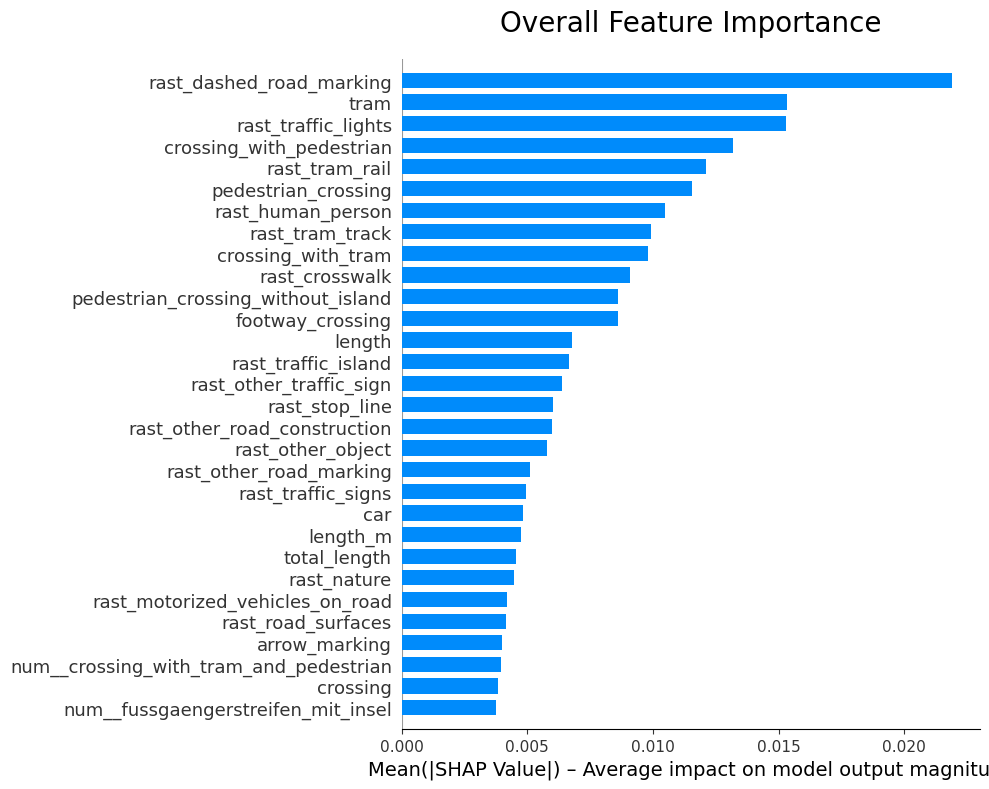

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import shap

class_labels = ["Geeignet", "erhöhte Anforderung", "anspruchsvoll", "nicht empfohlen"]

# === SHAP Werte berechnen ===
X_sample = X_te.sample(300)
explainer = shap.Explainer(best_pipe.named_steps["model"], best_pipe.named_steps["pre"].transform(X_sample))
shap_values = explainer(best_pipe.named_steps["pre"].transform(X_sample))
feature_names = best_pipe.named_steps["pre"].get_feature_names_out()

# === Feature Mapping (rast_ bleibt erhalten) ===
feature_name_map = {
    "num__rast_dashed_marking": "rast_dashed_road_marking",
    "num__rast_traffic_lights": "rast_traffic_lights",
    "num__crossing_with_pedestrian": "crossing_with_pedestrian",
    "num__tram": "tram",
    "num__fussgaengerstreifen": "pedestrian_crossing",
    "num__rast_human_person": "rast_human_person",
    "num__rast_tram_rail": "rast_tram_rail",
    "num__fussgaengerstreifen_ohne_insel": "pedestrian_crossing_without_island",
    "cat__footway_crossing": "footway_crossing",
    "num__crossing_with_tram": "crossing_with_tram",
    "num__tramgleis": "rast_tram_track",
    "num__rast_crosswalk": "rast_crosswalk",
    "num__length": "length",
    "num__rast_sign_other": "rast_other_traffic_sign",
    "num__rast_other": "rast_other_object",
    "num__rast_construction_road_other": "rast_other_road_construction",
    "num__rast_stop_line": "rast_stop_line",
    "num__rast_traffic_island": "rast_traffic_island",
    "num__rast_traffic_signs": "rast_traffic_signs",
    "num__length_m": "length_m",
    "num__rast_marking_other": "rast_other_road_marking",
    "num__total_len": "total_length",
    "num__auto": "car",
    "num__rast_vehicles_on_the_road_motorized": "rast_motorized_vehicles_on_road",
    "num__rast_nature": "rast_nature",
    "num__rast_roads_surfaces": "rast_road_surfaces",
    "num__pfeil": "arrow_marking",
    "num__veloweg": "bicycle_path",
    "num__rast_associated_with_bike": "rast_associated_with_bicycle",
    "num__crossing": "crossing"
}

clean_feature_names = [feature_name_map.get(f, f) for f in feature_names]

print("SHAP shape:", shap_values.values.shape)
shap_values_mean = np.mean(np.abs(shap_values.values), axis=2)

shap.summary_plot(
    shap_values_mean,
    feature_names=clean_feature_names,
    plot_type="bar",
    show=False,
    max_display=30
)

# === Plot-Layout ===
plt.gcf().set_size_inches(10, 8)
plt.title("Overall Feature Importance", fontsize=20, pad=20)
plt.xlabel("Mean(|SHAP Value|) – Average impact on model output magnitude", fontsize=14)
plt.tight_layout()
plt.savefig("./data/SHAP/feature_importance_overall.jpg", dpi=200)
plt.show()


In [4]:
# ===========================================
# Build a 0–100 safety score from class probabilities and save back
# ===========================================
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

# ---- Input/Output ----
ML_PATH = Path("./data/network_segments_with_predictions_plus_raster_plus_gt_ML.parquet")
OUT_PATH = Path("./data/network_segments_with_predictions_plus_raster_plus_gt_ML_new.parquet")

# ---- Class-to-score weights  ----
WEIGHTS = {
    "Geeignet": 100,
    "erhöhte Anforderung": 20,
    "anspruchsvoll": 10,
    "nicht empfohlen": 1,
}

# ---- Expected probability column names built from labels above ----
PROB_COLS = {label: f"prob_{label}" for label in WEIGHTS.keys()}

# ---- Load ----
edges = gpd.read_parquet(ML_PATH)

# ---- Validate/collect available probability columns ----
available = {label: col for label, col in PROB_COLS.items() if col in edges.columns}
missing = [label for label, col in PROB_COLS.items() if col not in edges.columns]

if missing:
    print(f"[INFO] Missing probability columns for labels (will ignore & renormalise others): {missing}")

if not available:
    raise ValueError("No probability columns found. Expected columns like 'prob_Geeignet', "
                     "'prob_erhöhte Anforderung', 'prob_anspruchsvoll', 'prob_nicht empfohlen'.")

# ---- Compute safety score ----
probs_mat = np.column_stack([edges[available[label]].to_numpy(dtype=float) for label in available.keys()])
weights_vec = np.array([WEIGHTS[label] for label in available.keys()], dtype=float)

# renormalise per row to sum to 1 over the available columns (handle NaNs safely)
row_sums = np.nansum(probs_mat, axis=1, keepdims=True)
safe_sums = np.where(row_sums == 0.0, 1.0, row_sums)
probs_norm = probs_mat / safe_sums

score = np.nansum(probs_norm * weights_vec, axis=1)

# clip into [0, 100] just in case of numeric drift
score = np.clip(score, 0, 100)

edges["safety_score"] = score
edges["safety_score_0_1"] = edges["safety_score"] / 100.0


edges.to_parquet(OUT_PATH, index=False)
print("Done.")
print(f"File updated: {OUT_PATH}")

Done.
File updated: data\network_segments_with_predictions_plus_raster_plus_gt_ML_new.parquet


## 2. Version: Rule-Based Classification


--- Safety Score Variants (Scaled + Shifted Sigmoid) ---
safety_sigmoid:
 count    102590.000000
mean         86.206375
std          17.679867
min           0.000000
5%           37.661136
50%          92.409657
95%          92.414185
max          92.414185
Name: safety_sigmoid, dtype: float64
safety_robust:
 count    1.025900e+05
mean     9.506931e+01
std      1.415797e+01
min      5.485201e-09
5%       6.704537e+01
50%      9.999292e+01
95%      1.000000e+02
max      1.000000e+02
Name: safety_robust, dtype: float64

Saved → ./data/edges_with_safety_variants.parquet


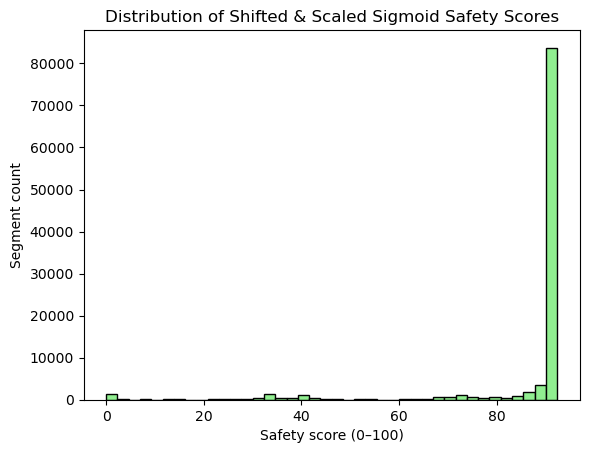

count    102590.000000
mean          1.029596
std           3.634058
min           0.000000
25%           0.000000
50%           0.001291
75%           0.337046
max          69.417503
Name: risk_raw, dtype: float64
0


In [52]:
# =========================
# School Route Safety – Kindergarten Pedestrian Version
# With Nonlinear Risk Amplification and Shifted+Scaled Sigmoid
# =========================

# === 0) Setup & Imports ===
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, Point
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import re, unicodedata, warnings
warnings.filterwarnings("ignore", category=UserWarning)

# === 1) Load and Prepare Data ===
gdf = gpd.read_parquet("./data/network_segments_with_predictions_plus_raster.parquet")

# Convert boolean-like columns to integers
bool_like = ["is_leaf"]
for col in bool_like:
    if col in gdf.columns:
        gdf[col] = gdf[col].astype(bool).astype(int)

# Identify raster and aggregated features
rast_cols = [c for c in gdf.columns if c.startswith("rast_")]
agg_cols = [
    "30er_zone_markierung", "30zone", "auto", "bushaltestelle",
    "fussgaengerstreifen", "fussgaengerstreifen_mit_insel",
    "fussgaengerstreifen_ohne_insel", "pfeil", "stopp_markierung",
    "tram", "tramgleis", "velo_markierung", "veloweg", "vortritt",
    "schule", "zug",
    "crossing_with_pedestrian", "crossing_without_pedestrian",
    "has_island_and_marked", "crossing_without_marking",
    "crossing_with_tram", "crossing_with_tram_and_pedestrian",
    "crossing_with_tram_without_pedestrian",
    "crossing_with_tram_has_island_and_marked",
    "crossing_with_tram_without_marking"
]
agg_cols = [c for c in agg_cols if c in gdf.columns]

# Fill missing values
for c in rast_cols + agg_cols:
    gdf[c] = gdf[c].fillna(0.0)

# Normalize segment length
if "length_m" not in gdf.columns:
    gdf["length_m"] = gdf.geometry.length
mm = MinMaxScaler()
gdf["length_norm"] = mm.fit_transform(gdf[["length_m"]])

# Normalize node degrees
for dcol in ["deg_u", "deg_v"]:
    if dcol in gdf.columns:
        rsc = RobustScaler()
        gdf[dcol + "_norm"] = rsc.fit_transform(gdf[[dcol]])
    else:
        gdf[dcol + "_norm"] = 0.0

# Optimize memory
for col in ["length_m", "length_norm", "deg_u_norm", "deg_v_norm"] + rast_cols + agg_cols:
    if col in gdf.columns and pd.api.types.is_float_dtype(gdf[col]):
        gdf[col] = gdf[col].astype("float32")

# === 2) Define Weights (Kindergarten-focused) ===
SOURCE_W_RAST = 0.25  # relative influence of raster detections

WEIGHTS_BASE = {
    # --- Crossings & Tram-related risk factors ---
    "crossing_without_marking": 3.0,
    "crossing_without_pedestrian": 1.2,
    "crossing_with_tram": 3.0,
    "crossing_with_tram_without_pedestrian": 6.0,
    "crossing_with_tram_has_island_and_marked": 1.2,

    # --- General traffic features ---
    "auto": 0.4,
    "tram": 1,
    "tramgleis": 1,
    "bushaltestelle": 0.3,
    "deg_u_norm": 0.1,
    "deg_v_norm": 0.1,

    # --- Protective features (slightly reduce risk) ---
    "30zone": -0.5,
    "30er_zone_markierung": -0.2,
    "fussgaengerstreifen": -0.5,
    "fussgaengerstreifen_mit_insel": -0.8,
    "stopp_markierung": -0.3,

    # --- Bicycle infrastructure (risky for small children) ---
    "veloweg": 0.5,
    "velo_markierung": 0.3,
    "vortritt": 0.1,

    # --- Raster detections ---
    "rast_crosswalk": -0.2 * SOURCE_W_RAST,
    "rast_traffic_lights": -0.2 * SOURCE_W_RAST,
    "rast_traffic_island": -0.1 * SOURCE_W_RAST,
    "rast_tram_rail": 0.4 * SOURCE_W_RAST,
    "rast_vehicles_on_the_road_motorized": 0.5 * SOURCE_W_RAST,
    "rast_dashed_marking": 0.3 * SOURCE_W_RAST,
    "rast_stop_line": -0.1 * SOURCE_W_RAST,
    "rast_street_light": -0.05 * SOURCE_W_RAST,
}

WEIGHTS_CROSSING_GATE = {
    "tram": 2.0,
    "tramgleis": 1.2,
    "rast_tram_rail": 0.6 * SOURCE_W_RAST,
}

WEIGHTS_ALL = {**WEIGHTS_BASE, **WEIGHTS_CROSSING_GATE}

# === 3) Compute Risk ===
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

# Ensure required columns exist
for col in set(list(WEIGHTS_BASE.keys()) + list(WEIGHTS_CROSSING_GATE.keys())):
    if col not in gdf.columns:
        gdf[col] = 0.0

cross_cols = [
    "crossing_with_pedestrian", "crossing_without_pedestrian",
    "has_island_and_marked", "crossing_without_marking",
    "crossing_with_tram", "crossing_with_tram_and_pedestrian",
    "crossing_with_tram_without_pedestrian",
    "crossing_with_tram_has_island_and_marked",
    "crossing_with_tram_without_marking",
]
for c in cross_cols:
    if c not in gdf.columns:
        gdf[c] = 0.0

# Identify crossing segments
is_crossing_flag = (gdf[cross_cols].sum(axis=1) > 0).astype(float)
if "footway" in gdf.columns:
    is_crossing_flag = np.maximum(
        is_crossing_flag, (gdf["footway"].astype(str).str.lower() == "crossing").astype(float)
    )

# Weighted sum of features
risk = np.zeros(len(gdf), dtype="float64")
for col, w in WEIGHTS_BASE.items():
    if col in gdf.columns:
        risk += w * gdf[col].astype(float).to_numpy()

# Apply crossing gate multipliers
gate = is_crossing_flag.to_numpy()
for col, w in WEIGHTS_CROSSING_GATE.items():
    if col in gdf.columns:
        risk += gate * w * gdf[col].astype(float).to_numpy()

# Add contextual multipliers
risk *= (1 + 0.5 * gdf["length_norm"].to_numpy())
risk *= (1 + 0.4 * (gdf["deg_u_norm"].to_numpy() + gdf["deg_v_norm"].to_numpy()))

# Nonlinear amplification – safe version
risk = np.clip(risk, a_min=0, a_max=None)
risk = np.power(risk, 1.2)


gdf["risk_raw"] = risk.astype("float32")

# === 3a) Safety Score Calculation (Scaled + Shifted Sigmoid) ===
SHIFT = -5.0
SCALE = 0.5  # controls the steepness and spread

scaled_risk = (gdf["risk_raw"] + SHIFT) * SCALE
gdf["safety_sigmoid"] = (1 - sigmoid(scaled_risk)) * 100.0

# Robust Min–Max scaling (1–99%)
q_lo, q_hi = np.percentile(gdf["risk_raw"], [1, 99])
r_clipped = np.clip(gdf["risk_raw"], q_lo, q_hi)
r_robust = (r_clipped - q_lo) / (q_hi - q_lo + 1e-9)
gdf["safety_robust"] = (1 - r_robust) * 100.0

# Display distribution summary
print("\n--- Safety Score Variants (Scaled + Shifted Sigmoid) ---")
for col in ["safety_sigmoid", "safety_robust"]:
    print(f"{col}:\n", gdf[col].describe(percentiles=[.05, .5, .95]))

# === 4) Export Results ===
keep_cols = [
    "fid", "footway", "highway", "length_m", "risk_raw",
    "safety_sigmoid", "safety_robust"
] + cross_cols
keep_cols = [c for c in keep_cols if c in gdf.columns] + [gdf.geometry.name]

gdf[keep_cols].to_parquet("./data/edges_with_safety_variants.parquet", index=False)
print("\nSaved → ./data/edges_with_safety_variants.parquet")

# === Optional: visualize the distribution ===
import matplotlib.pyplot as plt
plt.hist(gdf["safety_sigmoid"], bins=40, color="lightgreen", edgecolor="black")
plt.title("Distribution of Shifted & Scaled Sigmoid Safety Scores")
plt.xlabel("Safety score (0–100)")
plt.ylabel("Segment count")
plt.show()

print(gdf["risk_raw"].describe())
print(gdf["risk_raw"].isna().sum())



# Compute Safest Path

In [29]:
# =========================
# School Route Routing – Multi OD, Multi (alpha,beta)
# =========================
import os, itertools as it
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, Point
from shapely.ops import linemerge
from scipy.spatial import cKDTree
from joblib import Parallel, delayed

# ----------------------------
# Helpers
# ----------------------------
def _endpoints(line: LineString):
    a, b = line.coords[0], line.coords[-1]
    return (round(a[0], 6), round(a[1], 6)), (round(b[0], 6), round(b[1], 6))

def _edge_cost(length, safety, alpha=1.0, beta=1.0):
    """Compute edge cost ensuring no negative weights."""
    length = float(length)
    safety = float(safety)
    
    if np.isnan(safety):
        safety = 50.0  # neutral default for missing values
    else:
        safety = max(0.0, min(100.0, safety))

    cost = alpha * length + beta * (100.0 - safety) * (length / 100.0)
    return max(cost, 0.0)



def build_graph_simple(gdf, alpha=1.0, beta=1.5):
    G = nx.Graph()
    for _, row in gdf.iterrows():
        geom = row.geometry
        if not isinstance(geom, LineString) or geom.is_empty:
            continue
        u, v = _endpoints(geom)
        length = float(row["length_m"])
        safety = float(row["safety_score"])
        cost   = _edge_cost(length, safety, alpha, beta)
        if u not in G: G.add_node(u, x=u[0], y=u[1])
        if v not in G: G.add_node(v, x=v[0], y=v[1])
        attrs = dict(fid=row.get("fid"), length_m=length,
                     safety_score=safety, cost=cost, geom=geom)
        if G.has_edge(u, v):
            curr = G[u][v]
            better = (cost < curr["cost"]) or (
                np.isclose(cost, curr["cost"]) and safety < curr["safety_score"]
            )
            if better:
                G[u][v].update(attrs)
        else:
            G.add_edge(u, v, **attrs)
    return G

class NodeLocator:
    def __init__(self, G):
        coords = np.array([(n[0], n[1]) for n in G.nodes()])
        self.nodes = list(G.nodes())
        self.tree = cKDTree(coords)
    def nearest(self, pt: Point):
        _, idx = self.tree.query([pt.x, pt.y])
        return self.nodes[int(idx)]

def _make_edge_map(G):
    def key(u, v): return (u, v) if u <= v else (v, u)
    return {key(u,v): dict(data) for u,v,data in G.edges(data=True)}

def _summarize_path_from_map(path, emap):
    def key(u, v): return (u, v) if u <= v else (v, u)
    total_len, total_cost, min_safety = 0.0, 0.0, float("inf")
    worst_edge = None
    edges = []
    for u, v in zip(path[:-1], path[1:]):
        d = emap[key(u, v)]
        edges.append(d)
        total_len  += d["length_m"]
        total_cost += d["cost"]
        if d["safety_score"] < min_safety:
            min_safety = d["safety_score"]; worst_edge = d.get("fid")
    lw_mean = (sum(e["safety_score"] * e["length_m"] for e in edges) /
               max(total_len, 1e-9))
    return dict(
        nodes=path, edges=edges, total_length_m=total_len,
        total_cost=total_cost, safety_mean_lenweighted=lw_mean,
        safety_min_edge=min_safety, worst_edge_fid=worst_edge
    )

def make_routes_gdf(paths, crs, extra=None):
    feats = []
    for i, p in enumerate(paths, 1):
        geoms = [e["geom"] for e in p["edges"] if e.get("geom") is not None]
        if not geoms: continue
        route_geom = linemerge(geoms)
        rec = {
            "alt": i,
            "total_length_m": p["total_length_m"],
            "total_cost": p["total_cost"],
            "safety_mean": p["safety_mean_lenweighted"],
            "safety_min": p["safety_min_edge"],
            "worst_edge_fid": p.get("worst_edge_fid"),
            "geometry": route_geom
        }
        if extra: rec.update(extra)
        feats.append(rec)
    return gpd.GeoDataFrame(feats, geometry="geometry", crs=crs)

def k_routes_mp(G, src_pt: Point, dst_pt: Point, k=1):
    locator = NodeLocator(G)
    s, t = locator.nearest(src_pt), locator.nearest(dst_pt)
    gen = nx.shortest_simple_paths(G, s, t, weight="cost")
    paths = list(it.islice(gen, k))
    emap = _make_edge_map(G)
    return [_summarize_path_from_map(p, emap) for p in paths]

# =========================
# Main routing function
# =========================
def compute_routes_with_gpkg_and_cases(
    gdf_dict,
    od_pairs,
    alpha_beta_list=[(1.0,0.0),(1.0,1.0),(1.0,3.0),(0.0,1.0)],
    out_csv="./routing_results/routing_outcomes.csv",
    out_case_csv="./routing_results/routing_case_examples.csv",
    out_gpkg="./routing_results/routing_outcomes.gpkg"
):
    all_results, all_routes = [], []

    if os.path.exists(out_gpkg):
        os.remove(out_gpkg)

    for rid, (home, school) in enumerate(od_pairs, 1):
        print(f"\n=== Processing Route {rid}: {home} -> {school} ===")
        route_rows = []

        for method, gdf in gdf_dict.items():
            for (a, b) in alpha_beta_list:
                print(f"   {method}: alpha={a}, beta={b}")
                G_ab = build_graph_simple(gdf, alpha=a, beta=b)
                path_ab = k_routes_mp(G_ab, home, school, k=1)[0]

                result = dict(
                    method=method, route_id=f"R{rid}",
                    alpha=a, beta=b,
                    total_length_m=path_ab["total_length_m"],
                    safety_mean_lenweighted=path_ab["safety_mean_lenweighted"]
                )
                all_results.append(result)

                route_gdf = make_routes_gdf([path_ab], gdf.crs, extra=result)
                route_rows.append(route_gdf)

        layer_name = f"Route{rid}"
        route_layer = pd.concat(route_rows, ignore_index=True)
        route_layer.to_file(out_gpkg, driver="GPKG", layer=layer_name)
        all_routes.append(route_layer)

    # --- Full results
    df = pd.DataFrame(all_results)
    df.to_csv(out_csv, index=False)
    print(f"\n✅ Exported full results to: {out_csv}")
    print(f"✅ Exported routes to GPKG: {out_gpkg}")

    # --- Case examples: map to labels
    case_ab = {
        (1.0,0.0): "Fastest",
        (1.0,1.0): "Balanced",
        (1.0,3.0): "Safest",
        (0.0,1.0): "Absolute Safest"
    }
    df_cases = df[df[["alpha","beta"]].apply(tuple, axis=1).isin(case_ab.keys())].copy()
    df_cases["case"] = df_cases[["alpha","beta"]].apply(lambda r: case_ab[(r["alpha"], r["beta"])], axis=1)
    df_cases.to_csv(out_case_csv, index=False)
    print(f"✅ Exported case examples to: {out_case_csv}")

    return df, df_cases, pd.concat(all_routes, ignore_index=True)



# =========================
# Prepare ML and Rule-based networks
# =========================
ml_based = gpd.read_parquet(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\network_segments_with_predictions_plus_raster_plus_gt_ML_new.parquet"
)
if "safety_score" not in ml_based.columns:
    raise KeyError("Column 'safety_score' not found in ML dataset!")
if "length_m" not in ml_based.columns:
    ml_based["length_m"] = ml_based.geometry.length
ml_based["method"] = "ml"
gdf_ml = ml_based[["geometry", "length_m", "safety_score", "method"]].copy()

rule_based = gpd.read_parquet(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\edges_with_safety_variants.parquet"
)
rule_based = rule_based.rename(columns={"safety_sigmoid": "safety_score"})
if "safety_score" not in rule_based.columns:
    raise KeyError("Column 'safety_score' not found in Rule-based dataset!")
if "length_m" not in rule_based.columns:
    rule_based["length_m"] = rule_based.geometry.length
rule_based["method"] = "rule-based"
gdf_rb = rule_based[["geometry", "length_m", "safety_score", "method"]].copy()

print("ML-based network:", gdf_ml.shape, list(gdf_ml.columns))
print("Rule-based network:", gdf_rb.shape, list(gdf_rb.columns))

gdf_dict = {"ml": gdf_ml, "rule-based": gdf_rb}

# Define OD pairs
od_pairs = [
    (Point(2682135.2, 1248219.2), Point(2682433.4,1246621.1)),
    (Point(2682487.0, 1245619.3), Point(2685970.1,1251102.0)),
    (Point(2681126.64,1249444.25), Point(2680835.95,1248518.64)),
    (Point(2682613.36,1249342.43), Point(2683585.84,1248592.36))
]


df_all, df_cases, gdf_routes = compute_routes_with_gpkg_and_cases(
    gdf_dict,
    od_pairs,
    alpha_beta_list=[
        (1.0, 0.0),  # Fastest
        (1.0, 1.0),  # Balanced
        (1.0, 3.0),  # Safe
        (0.0, 1.0)   # Safest (extreme case)
    ],
    out_case_csv="./routing_results/routing_case_examples.csv",
    out_gpkg="./routing_results/routing_outcomes.gpkg"
)



ML-based network: (102590, 4) ['geometry', 'length_m', 'safety_score', 'method']
Rule-based network: (102590, 4) ['geometry', 'length_m', 'safety_score', 'method']

=== Processing Route 1: POINT (2682135.2 1248219.2) -> POINT (2682433.4 1246621.1) ===
   ml: alpha=1.0, beta=0.0
   ml: alpha=1.0, beta=1.0
   ml: alpha=1.0, beta=3.0
   ml: alpha=0.0, beta=1.0
   rule-based: alpha=1.0, beta=0.0
   rule-based: alpha=1.0, beta=1.0
   rule-based: alpha=1.0, beta=3.0
   rule-based: alpha=0.0, beta=1.0

=== Processing Route 2: POINT (2682487 1245619.3) -> POINT (2685970.1 1251102) ===
   ml: alpha=1.0, beta=0.0
   ml: alpha=1.0, beta=1.0
   ml: alpha=1.0, beta=3.0
   ml: alpha=0.0, beta=1.0
   rule-based: alpha=1.0, beta=0.0
   rule-based: alpha=1.0, beta=1.0
   rule-based: alpha=1.0, beta=3.0
   rule-based: alpha=0.0, beta=1.0

=== Processing Route 3: POINT (2681126.64 1249444.25) -> POINT (2680835.95 1248518.64) ===
   ml: alpha=1.0, beta=0.0
   ml: alpha=1.0, beta=1.0
   ml: alpha=1.0, beta

# Compute Safety Score Statistics

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Setup output directory ===
output_dir = r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\Safety_Score_Statistics\plots"
os.makedirs(output_dir, exist_ok=True)

# === 1) Load input data ===
rule_based = gpd.read_parquet(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\edges_with_safety_variants.parquet"
)
ml_based = gpd.read_parquet(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\network_segments_with_predictions_plus_raster_plus_gt_ML_new.parquet"
)

# Select the right score columns
rule_based = rule_based.rename(columns={"safety_sigmoid": "safety_score"})
rule_based["method"] = "rule-based"

ml_based = ml_based.rename(columns={"safety_score": "safety_score"})
ml_based["method"] = "ml"

# Combine
segments_all = pd.concat([rule_based, ml_based], ignore_index=True)
segments_all = gpd.GeoDataFrame(segments_all, geometry="geometry", crs=rule_based.crs)

# === 2) Load Stadtkreise and Quartiere ===
kreise = gpd.read_file(
    r"C:\Users\claud\Downloads\a234746484f543e7a81c978a3e38b9bf\Stadtkreise_und_Quartiere_Zurich_und_Winterthur_-OGD\UP_STADTKREISE_F.shp"
)
kreise["STADTKREIS"] = kreise["STADTKREIS"].str.replace("Kreis", "District", regex=False)

quartiere = gpd.read_file(
    r"C:\Users\claud\Downloads\a234746484f543e7a81c978a3e38b9bf\Stadtkreise_und_Quartiere_Zurich_und_Winterthur_-OGD\UP_STADTQUARTIERE_F.shp"
)

# === 3) Spatial join with Stadtkreise ===
segments_kreise = gpd.sjoin(segments_all, kreise, how="left", predicate="intersects")
stats_kreise = (
    segments_kreise.groupby(["method", "STADTKREIS"])["safety_score"]
    .agg(["count", "min", "max", "mean", "median", "std"])
    .reset_index()
)
stats_kreise.to_csv(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\Safety_Score_Statistics\safety_score_stats_per_kreis.csv",
    index=False,
)
segments_kreise["STADTKREIS"] = segments_kreise["STADTKREIS"].str.replace("Kreis", "District", regex=False)

# === 4) Spatial join with Quartiere ===
segments_quartiere = gpd.sjoin(segments_all, quartiere, how="left", predicate="intersects")
stats_quartiere = (
    segments_quartiere.groupby(["method", "QUARTIERNA"])["safety_score"]
    .agg(["count", "min", "max", "mean", "median", "std"])
    .reset_index()
)
stats_quartiere.to_csv(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\Safety_Score_Statistics\safety_score_stats_per_quartier.csv",
    index=False,
)

# === Statistics over all segments ===
stats_overall = (
    segments_all.groupby("method")["safety_score"]
    .agg(["count", "min", "max", "mean", "median", "std"])
    .reset_index()
)

# Speichern als CSV
stats_overall.to_csv(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\Safety_Score_Statistics\safety_score_stats_overall.csv",
    index=False,
)

print("Rule-based non-null safety scores:", rule_based["safety_score"].notna().sum())
print("ML-based non-null safety scores:", ml_based["safety_score"].notna().sum())
print("Combined non-null safety scores:", segments_all["safety_score"].notna().sum())
print(rule_based.select_dtypes(include=["float", "int"]).count())



Rule-based non-null safety scores: 102590
ML-based non-null safety scores: 102590
Combined non-null safety scores: 205180
fid                                         102590
length_m                                    102590
risk_raw                                    102590
safety_score                                102590
safety_robust                               102590
crossing_with_pedestrian                    102590
crossing_without_pedestrian                 102590
has_island_and_marked                       102590
crossing_without_marking                    102590
crossing_with_tram                          102590
crossing_with_tram_and_pedestrian           102590
crossing_with_tram_without_pedestrian       102590
crossing_with_tram_has_island_and_marked    102590
crossing_with_tram_without_marking          102590
dtype: int64


In [17]:
# ========================
# Compute Maps and Statistics for Safety Scores
# ========================

method_labels = {"rule-based": "Rule-based Method", "ml": "Machine Learning Method"}
threshold = 20

# === 5) Choropleth maps (Rule-based vs ML) ===
vmin = segments_all["safety_score"].min()
vmax = segments_all["safety_score"].max()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
segments_all[segments_all["method"]=="rule-based"].plot(
    column="safety_score", cmap="RdBu", linewidth=0.5, legend=True,
    legend_kwds={"label": "Safety Score", "orientation": "vertical"},
    ax=ax[0], vmin=vmin, vmax=vmax
)
ax[0].set_title("Rule-based Safety Scores per Segment")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

segments_all[segments_all["method"]=="ml"].plot(
    column="safety_score", cmap="RdBu", linewidth=0.5, legend=True,
    legend_kwds={"label": "Safety Score", "orientation": "vertical"},
    ax=ax[1], vmin=vmin, vmax=vmax
)
ax[1].set_title("ML-based Safety Scores per Segment")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "choropleth_rule_vs_ml.jpg"), dpi=300)
plt.close()


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os

# === 6) Boxplots (Safety Scores by District) ===
segments_kreise_reset = segments_kreise.reset_index(drop=True)
segments_kreise_reset["STADTKREIS_NUM"] = (
    segments_kreise_reset["STADTKREIS"].astype(str).str.extract(r"(\d+)")
)
segments_kreise_reset = segments_kreise_reset.dropna(subset=["STADTKREIS_NUM"])
segments_kreise_reset["STADTKREIS_NUM"] = segments_kreise_reset["STADTKREIS_NUM"].astype(int)
segments_kreise_reset = segments_kreise_reset.sort_values("STADTKREIS_NUM")

methods = ["rule-based", "ml"]

# --- Stil & Farben ---
sns.set_theme(style="whitegrid", font_scale=1.6)  # deutlich grössere Schrift
colors = {
    "rule-based": "#E69F00",  # Orange
    "ml": "#0072B2"           # Blau
}

fig, axes = plt.subplots(2, 1, figsize=(13, 12), sharex=True)

for ax, method in zip(axes, methods):
    data = segments_kreise_reset[segments_kreise_reset["method"] == method]

    # Boxplot (eine Farbe pro Methode)
    sns.boxplot(
        data=data,
        x="STADTKREIS_NUM",
        y="safety_score",
        order=sorted(data["STADTKREIS_NUM"].unique()),
        ax=ax,
        width=0.6,
        fliersize=3,
        linewidth=1.2,
        color=colors[method]
    )

    # Mittelwert-Diamant
    sns.pointplot(
        data=data,
        x="STADTKREIS_NUM",
        y="safety_score",
        order=sorted(data["STADTKREIS_NUM"].unique()),
        ax=ax,
        estimator="mean",
        color="black",
        markers="D",    # Diamant
        scale=0.8,      # etwas grösser
        errwidth=0,
        linestyles=""
    )

    # Titel und Achsen
    ax.set_title(f"Distribution of Safety Scores per District ({method_labels[method]})",
                 fontsize=18, pad=12, weight="bold")
    ax.set_xlabel("District", fontsize=16, labelpad=10)
    ax.set_ylabel("Safety Score", fontsize=16, labelpad=10)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 105)
    ax.grid(True, axis='y', linestyle="--", alpha=0.6)

# --- Legende ---
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
mean_handle = mlines.Line2D(
    [], [], color="black", marker="D", linestyle="None",
    markersize=6, label="Mean"
)

outlier_handle = mlines.Line2D(
    [], [], marker="o", linestyle="None",
    markerfacecolor="white", markeredgecolor="black",
    markersize=5, alpha=0.9, label="Outliers"
)

fig.legend(
    handles=[mean_handle, outlier_handle],
    loc="lower center",
    ncol=3,
    fontsize=14,
    frameon=False,
    bbox_to_anchor=(0.5, 0)
)
plt.savefig(os.path.join(output_dir, "boxplot_scores_per_district.jpg"), dpi=200, bbox_inches="tight")
plt.close()

# === 7) Scatterplot: Rule-based vs ML per Segment ===
rule_reset = rule_based.reset_index().rename(columns={"index": "seg_index"})
ml_reset   = ml_based.reset_index().rename(columns={"index": "seg_index"})
compare_df = rule_reset[["seg_index", "safety_score"]].rename(columns={"safety_score": "rule-based"})
compare_df = compare_df.merge(
    ml_reset[["seg_index", "safety_score"]].rename(columns={"safety_score": "ml"}),
    on="seg_index"
)

plt.figure(figsize=(6,6))
plt.scatter(compare_df["rule-based"], compare_df["ml"], alpha=0.5)
plt.plot([0,100], [0,100], "r--")
plt.title("Comparison of Rule-based vs ML per Segment")
plt.xlabel("Rule-based Safety Score")
plt.ylabel("ML Safety Score")
plt.savefig(os.path.join(output_dir, "scatter_rule_vs_ml.jpg"), dpi=200)
plt.close()


# === 8) Histogram / Density plot ===
plt.figure(figsize=(10,5))
sns.kdeplot(segments_all[segments_all["method"]=="rule-based"]["safety_score"],
            label="Rule-based", fill=True)
sns.kdeplot(segments_all[segments_all["method"]=="ml"]["safety_score"],
            label="ML", fill=True)
plt.title("Distribution of Safety Scores (All Segments)")
plt.xlabel("Safety Score")
plt.ylabel("Density")
plt.legend(title="Method")
plt.savefig(os.path.join(output_dir, "distribution_scores.jpg"), dpi=200)
plt.close()


# === 9) Difference map (ML - Rule-based) ===
compare_df["diff"] = compare_df["ml"] - compare_df["rule-based"]
segments_diff = rule_reset.merge(compare_df[["seg_index", "diff"]], on="seg_index")

plt.figure(figsize=(10,8))
segments_diff.plot(
    column="diff",
    cmap="RdBu",
    legend=True,
    vmin=-25, vmax=25,
    linewidth=0.2,
    legend_kwds={"label": "Difference (ML - RB)", "orientation": "vertical"}
)
plt.title("Difference in Safety Score (ML - Rule-based)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig(os.path.join(output_dir, "difference_map.jpg"), dpi=200, bbox_inches="tight")
plt.close()

# === 10) Barplot: Mean Safety Score per District ===
mean_scores = (
    segments_kreise_reset.groupby(["method", "STADTKREIS_NUM"])["safety_score"]
    .mean().reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(data=mean_scores, x="STADTKREIS_NUM", y="safety_score", hue="method")
plt.title("Mean Safety Score per District")
plt.xlabel("District (numeric)")
plt.ylabel("Mean Safety Score")
plt.legend(title="Method")
plt.savefig(os.path.join(output_dir, "barplot_mean_scores_per_district.jpg"), dpi=200)
plt.close()


# === 11) Violinplots: Distribution per District ===
plt.figure(figsize=(12,6))
sns.violinplot(data=segments_kreise_reset, x="STADTKREIS_NUM",
               y="safety_score", hue="method", split=True)
plt.title("Distribution of Safety Scores per District (Violinplot)")
plt.xlabel("District (numeric)")
plt.ylabel("Safety Score")
plt.legend(title="Method")
plt.savefig(os.path.join(output_dir, "violinplot_scores_per_district.jpg"), dpi=200)
plt.close()


import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

for method in ["rule-based", "ml"]:
    seg_kreise_m = segments_kreise[segments_kreise["method"] == method]

    mean_per_district = (
        seg_kreise_m.groupby("STADTKREIS")["safety_score"]
        .mean().reset_index()
    )

    # Replace "Kreis" → "District" for display
    mean_per_district["STADTKREIS_LABEL"] = (
        mean_per_district["STADTKREIS"].astype(str).str.replace("Kreis", "District", regex=False)
    )

    kreise_plot = kreise.merge(mean_per_district, on="STADTKREIS")

    fig, ax = plt.subplots(figsize=(8, 8))
    kreise_plot.plot(
        column="safety_score",
        cmap="cividis",
        legend=True,
        vmin=70, vmax=100,
        legend_kwds={"label": "Mean Safety Score", "orientation": "vertical"},
        edgecolor="k",
        linewidth=0.5,
        ax=ax
    )

    # --- Labels: District + Mean ---
    for idx, row in kreise_plot.iterrows():
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        label = f"{row['STADTKREIS_LABEL']}\nMean: {row['safety_score']:.1f}"
        txt = ax.text(
            x, y, label,
            ha="center", va="center", fontsize=6, color="black", weight="bold"
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2.5, foreground="white"),
            path_effects.Normal()
        ])

    ax.set_title(f"Mean Safety Score per District ({method_labels[method]})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.savefig(
        os.path.join(output_dir, f"choropleth_mean_score_per_district_{method}.jpg"),
        dpi=200, bbox_inches="tight"
    )
    plt.close()



import matplotlib.patheffects as path_effects

# === 14) Choropleth: Mean Safety Score per Quarter (by Method) ===
for method in ["rule-based", "ml"]:
    seg_quart_m = segments_quartiere[segments_quartiere["method"] == method]

    mean_per_quarter = (
        seg_quart_m.groupby("QUARTIERNA")["safety_score"]
        .mean().reset_index()
    )
    quartiere_plot = quartiere.merge(mean_per_quarter, on="QUARTIERNA")

    fig, ax = plt.subplots(figsize=(10, 10))
    quartiere_plot.plot(
        column="safety_score",
        cmap="cividis",              # colorblind-friendly colormap
        legend=True,
        vmin=70, vmax=100,           # fixed scale
        legend_kwds={
            "label": "Mean Safety Score",
            "orientation": "vertical"
        },
        edgecolor="k",
        linewidth=0.5,
        ax=ax
    )

    # Add labels with fontsize 5 and white buffer
    for idx, row in quartiere_plot.iterrows():
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        txt = ax.text(
            x, y, str(row["QUARTIERNA"]),
            ha="center", va="center",
            fontsize=5, color="black"
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=1.2, foreground="white"),
            path_effects.Normal()
        ])

    ax.set_title(f"Mean Safety Score per Quarter ({method_labels[method]})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.savefig(
        os.path.join(output_dir, f"choropleth_mean_score_per_quarter_{method}.jpg"),
        dpi=200,
        bbox_inches="tight"
    )
    plt.close()


import matplotlib.patheffects as path_effects

# === 13 & 14) Choropleths: Counts and Shares of Edges below threshold (by Method) ===
for method in ["rule-based", "ml"]:
    seg_kreise_m = segments_kreise[segments_kreise["method"] == method]
    seg_quart_m  = segments_quartiere[segments_quartiere["method"] == method]

    # --- Counts per District ---
    low_districts = (
        seg_kreise_m.groupby("STADTKREIS")
        .apply(lambda df: (df["safety_score"] < threshold).sum())
        .reset_index(name="count_below_threshold")
    )
    kreise_count = kreise.merge(low_districts, on="STADTKREIS")

    fig, ax = plt.subplots(figsize=(8, 8))
    kreise_count.plot(
        column="count_below_threshold",
        cmap="cividis",  # colorblind-friendly colormap
        legend=True,
        legend_kwds={"label": f"Count of Edges < {threshold}", "orientation": "vertical"},
        edgecolor="k",
        linewidth=0.5,
        ax=ax
    )
    for idx, row in kreise_count.iterrows():
        txt = ax.text(
            row.geometry.centroid.x,
            row.geometry.centroid.y,
            str(row["STADTKREIS"]),
            ha="center", va="center", fontsize=8, color="black", weight="bold"
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground="white"),
            path_effects.Normal()
        ])
    ax.set_title(f"Number of Edges with Safety Score < {threshold} per District ({method_labels[method]})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(os.path.join(output_dir, f"choropleth_edges_below{threshold}_per_district_{method}.jpg"), dpi=200)
    plt.close()

    # --- Counts per Quarter ---
    low_quarters = (
        seg_quart_m.groupby("QUARTIERNA")
        .apply(lambda df: (df["safety_score"] < threshold).sum())
        .reset_index(name="count_below_threshold")
    )
    quartiere_count = quartiere.merge(low_quarters, on="QUARTIERNA")

    fig, ax = plt.subplots(figsize=(10, 10))
    quartiere_count.plot(
        column="count_below_threshold",
        cmap="cividis",
        legend=True,
        legend_kwds={"label": f"Count of Edges < {threshold}", "orientation": "vertical"},
        edgecolor="k",
        linewidth=0.5,
        ax=ax
    )
    for idx, row in quartiere_count.iterrows():
        txt = ax.text(
            row.geometry.centroid.x,
            row.geometry.centroid.y,
            str(row["QUARTIERNA"]),
            ha="center", va="center", fontsize=5, color="black"
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=1.2, foreground="white"),
            path_effects.Normal()
        ])
    ax.set_title(f"Number of Edges with Safety Score < {threshold} per Quarter ({method_labels[method]})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(os.path.join(output_dir, f"choropleth_edges_below{threshold}_per_quarter_{method}.jpg"), dpi=200)
    plt.close()

    # --- Shares per District ---
    low_districts_share = (
        seg_kreise_m.groupby("STADTKREIS")["safety_score"]
        .agg(total_edges="count",
             count_below=lambda s: (s < threshold).sum())
        .reset_index()
    )
    low_districts_share["pct_below_threshold"] = (
        100 * low_districts_share["count_below"] / low_districts_share["total_edges"]
    )
    kreise_share = kreise.merge(low_districts_share, on="STADTKREIS")

    fig, ax = plt.subplots(figsize=(8, 8))
    kreise_share.plot(
        column="pct_below_threshold",
        cmap="cividis",
        legend=True,
        legend_kwds={"label": f"Percentage of Edges < {threshold}", "orientation": "vertical"},
        edgecolor="k",
        linewidth=0.5,
        ax=ax
    )
    for idx, row in kreise_share.iterrows():
        txt = ax.text(
            row.geometry.centroid.x,
            row.geometry.centroid.y,
            str(row["STADTKREIS"]),
            ha="center", va="center", fontsize=8, color="black", weight="bold"
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground="white"),
            path_effects.Normal()
        ])
    ax.set_title(f"% of Edges with Safety Score < {threshold} per District ({method_labels[method]})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(os.path.join(output_dir, f"choropleth_pct_edges_below{threshold}_per_district_{method}.jpg"), dpi=200)
    plt.close()

    # --- Shares per Quarter ---
    low_quarters_share = (
        seg_quart_m.groupby("QUARTIERNA")["safety_score"]
        .agg(total_edges="count",
             count_below=lambda s: (s < threshold).sum())
        .reset_index()
    )
    low_quarters_share["pct_below_threshold"] = (
        100 * low_quarters_share["count_below"] / low_quarters_share["total_edges"]
    )
    quartiere_share = quartiere.merge(low_quarters_share, on="QUARTIERNA")

    fig, ax = plt.subplots(figsize=(10, 10))
    quartiere_share.plot(
        column="pct_below_threshold",
        cmap="cividis",
        legend=True,
        legend_kwds={"label": f"% of Edges < {threshold}", "orientation": "vertical"},
        edgecolor="k",
        linewidth=0.5,
        ax=ax
    )
    for idx, row in quartiere_share.iterrows():
        txt = ax.text(
            row.geometry.centroid.x,
            row.geometry.centroid.y,
            str(row["QUARTIERNA"]),
            ha="center", va="center", fontsize=5, color="black"
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=1.2, foreground="white"),
            path_effects.Normal()
        ])
    ax.set_title(f"% of Edges with Safety Score < {threshold} per Quarter ({method_labels[method]})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(os.path.join(output_dir, f"choropleth_pct_edges_below{threshold}_per_quarter_{method}.jpg"), dpi=200)
    plt.close()



# 15) Mean Safety Score per District (by Method) - sorted by district number
palette = sns.color_palette("viridis", n_colors=2)

# === 15) Mean Safety Score per District (by Method) ===
mean_scores_district = (
    segments_kreise_reset.groupby(["method", "STADTKREIS_NUM"])["safety_score"]
    .mean().reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=mean_scores_district,
    x="STADTKREIS_NUM", y="safety_score", hue="method",
    order=sorted(mean_scores_district["STADTKREIS_NUM"].unique()),
    palette=palette
)
plt.title("Mean Safety Score per District (by Method)")
plt.xlabel("District (numeric)")
plt.ylabel("Mean Safety Score")
plt.ylim(50, 100)  # fix scale for comparability
plt.legend(
    title="Method",
    labels=[method_labels[m] for m in mean_scores_district["method"].unique()]
)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "barplot_mean_scores_per_district_by_method.jpg"), dpi=200)
plt.close()

# === 16) Mean Safety Score per Quarter (by Method) ===
mean_scores_quarter = (
    segments_quartiere.groupby(["method", "QUARTIERNA"])["safety_score"]
    .mean().reset_index()
)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=mean_scores_quarter.sort_values("safety_score", ascending=False),
    y="QUARTIERNA", x="safety_score", hue="method",
    palette=palette
)
plt.title("Mean Safety Score per Quarter (by Method)")
plt.xlabel("Mean Safety Score")
plt.ylabel("Quarter")
plt.xlim(50, 100)  # fix scale for comparability
plt.legend(title="Method", labels=[method_labels[m] for m in mean_scores_quarter["method"].unique()])
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "barplot_mean_scores_per_quarter_by_method.jpg"), dpi=200)
plt.close()


# === 17) % of Edges below Threshold per District (by Method) ===
share_districts = (
    segments_kreise_reset.groupby(["method", "STADTKREIS_NUM"])["safety_score"]
    .agg(total_edges="count", count_below=lambda s: (s < threshold).sum())
    .reset_index()
)
share_districts["pct_below_threshold"] = (
    100 * share_districts["count_below"] / share_districts["total_edges"]
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=share_districts,
    x="STADTKREIS_NUM", y="pct_below_threshold", hue="method",
    order=sorted(share_districts["STADTKREIS_NUM"].unique()),
    palette=palette
)
plt.title(f"% of Edges with Safety Score < {threshold} per District (by Method)")
plt.xlabel("District (numeric)")
plt.ylabel("Percentage of Edges below Threshold")
plt.ylim(0, 100)  # fix scale
plt.legend(title="Method", labels=[method_labels[m] for m in share_districts["method"].unique()])
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"barplot_pct_edges_below{threshold}_per_district_by_method.jpg"), dpi=200)
plt.close()


# === 18) % of Edges below Threshold per Quarter (by Method) ===
share_quarters = (
    segments_quartiere.groupby(["method", "QUARTIERNA"])["safety_score"]
    .agg(total_edges="count", count_below=lambda s: (s < threshold).sum())
    .reset_index()
)
share_quarters["pct_below_threshold"] = (
    100 * share_quarters["count_below"] / share_quarters["total_edges"]
)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=share_quarters.sort_values("pct_below_threshold", ascending=False),
    y="QUARTIERNA", x="pct_below_threshold", hue="method",
    palette=palette
)
plt.title(f"% of Edges with Safety Score < {threshold} per Quarter (by Method)")
plt.xlabel("Percentage of Edges below Threshold")
plt.ylabel("Quarter")
plt.xlim(0, 100)
plt.legend(title="Method", labels=[method_labels[m] for m in share_quarters["method"].unique()])
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"barplot_pct_edges_below{threshold}_per_quarter_by_method.jpg"), dpi=200)
plt.close()

print(output_dir)

D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\Safety_Score_Statistics\plots


<Figure size 1000x800 with 0 Axes>

# Export GeoJSON for claudewidmer.ch website

In [83]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np

# === 1) Load input datasets ===
rule_based = gpd.read_parquet(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\edges_with_safety_variants.parquet"
)
ml_based = gpd.read_parquet(
    r"D:\Masterarbeit\03_Model\Scripts\3_Classificatiaon\3_Classification\data\network_segments_with_predictions_plus_raster_plus_gt_ML_new.parquet"
)

kreise = gpd.read_file(
    r"C:\Users\claud\Downloads\a234746484f543e7a81c978a3e38b9bf\Stadtkreise_und_Quartiere_Zurich_und_Winterthur_-OGD\UP_STADTKREISE_F.shp"
)


# Keep only needed columns
rule_based = rule_based[["fid", "geometry", "safety_sigmoid"]].rename(columns={"safety_sigmoid": "safety_score_RB"})
ml_based   = ml_based[["fid", "safety_score"]].rename(columns={"safety_score": "safety_score_ML"})

# Merge on unique ID
merged = rule_based.merge(ml_based, on="fid", how="inner")

# Optional: drop null geometries
merged = merged[merged.geometry.notnull()]

# === Spatial join with Stadtkreise (keep only STADTKREIS)
merged_kreise = gpd.sjoin(merged, kreise[["STADTKREIS", "geometry"]], how="left", predicate="intersects")

# Keep only relevant columns
merged_kreise = merged_kreise[["fid", "STADTKREIS", "safety_score_RB", "safety_score_ML", "geometry"]]

# Filter invalid district 0 if present
merged_kreise = merged_kreise[merged_kreise["STADTKREIS"] != "Kreis 0"]

# Convert to WGS84
merged_kreise = merged_kreise.to_crs(4326)

# Cast to small integer for minimal file size
merged_kreise["safety_score_RB"] = merged_kreise["safety_score_RB"].round().astype("uint8")
merged_kreise["safety_score_ML"] = merged_kreise["safety_score_ML"].round().astype("uint8")

# Export compact GeoJSON
merged_kreise.to_file("./data/data_geojson.geojson", driver="GeoJSON")